<a href="https://colab.research.google.com/github/isadays/DeepLearning_Specialization/blob/main/CustomerModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import math


In [ ]:

# -----------------------------------
# Positional Encoding Module
# -----------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        """
        Adds positional information to token embeddings.
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x: Tensor of shape (batch_size, seq_len, d_model)
        """
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# -----------------------------------
# Customer Feature Encoder Module
# -----------------------------------
class CustomerFeatureEncoder(nn.Module):
    def __init__(self, input_dim, d_model):
        """
        Encodes structured customer data into a vector embedding.
        """
        super(CustomerFeatureEncoder, self).__init__()
        self.fc = nn.Linear(input_dim, d_model)

    def forward(self, customer_features):
        """
        customer_features: Tensor of shape (batch_size, input_dim)
        Returns:
            memory: Tensor of shape (batch_size, 1, d_model)
        """
        memory = self.fc(customer_features)
        memory = memory.unsqueeze(1)  # add a sequence dimension (length=1)
        return memory

# -----------------------------------
# Transformer-based NLG Module
# -----------------------------------
class TransformerNLGModel(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_layers=6,
                 dim_feedforward=2048, dropout=0.1):
        """
        Decoder-only transformer model for text generation.
        """
        super(TransformerNLGModel, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)

        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)

        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        """
        Args:
            tgt: Target token sequence input (batch_size, tgt_seq_length)
            memory: Conditioning memory from customer data (batch_size, mem_seq_length, d_model)
        Returns:
            logits: Unnormalized scores over the vocabulary (batch_size, tgt_seq_length, vocab_size)
        """
        # Embed target tokens and add positional encoding
        tgt_emb = self.token_embedding(tgt)         # (batch_size, tgt_seq_length, d_model)
        tgt_emb = self.positional_encoding(tgt_emb)   # (batch_size, tgt_seq_length, d_model)

        # Transformer expects shape: (seq_length, batch_size, d_model)
        tgt_emb = tgt_emb.transpose(0, 1)
        memory = memory.transpose(0, 1)

        decoder_output = self.transformer_decoder(tgt_emb, memory,
                                                  tgt_mask=tgt_mask,
                                                  memory_mask=memory_mask)
        decoder_output = decoder_output.transpose(0, 1)  # (batch_size, tgt_seq_length, d_model)
        logits = self.fc_out(decoder_output)
        return logits

# -----------------------------------
# Complete Personalized NLG Model
# -----------------------------------
class PersonalizedNLGModel(nn.Module):
    def __init__(self, vocab_size, customer_feature_dim, d_model=512, nhead=8,
                 num_layers=6, dim_feedforward=2048, dropout=0.1):
        """
        Combines the customer feature encoder and transformer-based NLG module.
        """
        super(PersonalizedNLGModel, self).__init__()
        self.customer_encoder = CustomerFeatureEncoder(customer_feature_dim, d_model)
        self.nlg_model = TransformerNLGModel(vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout)

    def forward(self, tgt, customer_features, tgt_mask=None, memory_mask=None):
        """
        Args:
            tgt: Target token sequence input (batch_size, tgt_seq_length)
            customer_features: Structured customer data (batch_size, customer_feature_dim)
        Returns:
            logits: Unnormalized scores over the vocabulary (batch_size, tgt_seq_length, vocab_size)
        """
        memory = self.customer_encoder(customer_features)  # (batch_size, 1, d_model)
        logits = self.nlg_model(tgt, memory, tgt_mask=tgt_mask, memory_mask=memory_mask)
        return logits

# -----------------------------------
# Synthetic Customer Dataset
# -----------------------------------
class SyntheticCustomerDataset(Dataset):
    def __init__(self, num_samples, seq_length, vocab_size):
        """
        Generates synthetic customer data with realistic features and a personalized target message.

        Each sample contains:
          - Customer features:
              1. Age (18 to 80 years)
              2. Annual Income (20k to 150k USD)
              3. Account Balance (0 to 100k USD)
              4. Tenure (years as a customer, 1 to 30)
              5. Credit Score (300 to 850)
              6. Number of Products used (1 to 5)
              7. Risk Profile (0: Low, 1: Medium, 2: High)
              8. Loyalty Score (0 to 1)
              9. Region (0 to 4)
             10. Gender (0: Female, 1: Male)
          - Target message tokens (of length `seq_length`):
              - First token: greeting token—200 if loyalty score > 0.7, else 201.
              - Remaining tokens: computed from account balance (scaled down).
        """
        self.num_samples = num_samples
        self.seq_length = seq_length
        self.vocab_size = vocab_size
        self.data = []

        for _ in range(num_samples):
            # Generate realistic customer features using numpy distributions
            age = np.random.randint(18, 81)                        # Age: 18-80 years
            income = np.random.uniform(20000, 150000)              # Annual income in USD
            account_balance = np.random.uniform(0, 100000)         # Account balance in USD
            tenure = np.random.randint(1, 31)                      # Tenure in years: 1-30
            credit_score = np.random.randint(300, 851)             # Credit score: 300-850
            num_products = np.random.randint(1, 6)                 # Number of products: 1-5
            risk_profile = np.random.choice([0, 1, 2])             # Risk profile: 0,1,2
            loyalty_score = np.random.uniform(0, 1)                # Loyalty score: 0-1
            region = np.random.randint(0, 5)                       # Region: 0-4
            gender = np.random.choice([0, 1])                      # Gender: 0: Female, 1: Male

            features = torch.tensor(
                [age, income, account_balance, tenure, credit_score,
                 num_products, risk_profile, loyalty_score, region, gender],
                dtype=torch.float
            )

            # Construct the target message:
            # Greeting token: 200 if loyalty_score > 0.7, else 201.
            greeting_token = 200 if loyalty_score > 0.7 else 201

            # Account-related tokens: Use account_balance scaled down.
            # Divide balance by 1000, then take modulo to ensure tokens are within vocab.
            base = int(account_balance / 1000) % (vocab_size - (seq_length - 1))
            account_tokens = [base + i for i in range(seq_length - 1)]

            target_seq = torch.tensor([greeting_token] + account_tokens, dtype=torch.long)

            self.data.append((features, target_seq))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]


In [ ]:
# -----------------------------------
# Training and Evaluation Loop
# -----------------------------------
def train_model():
    # Hyperparameters
    num_samples = 1500
    seq_length = 10             # Length of the target message (tokens)
    vocab_size = 10000          # Vocabulary size
    customer_feature_dim = 10   # 10 customer features as defined in the dataset
    batch_size = 32
    num_epochs = 20
    learning_rate = 1e-3

    # Create synthetic dataset
    dataset = SyntheticCustomerDataset(num_samples, seq_length, vocab_size)

    # Optionally split into train/validation/test; here we use all for training for simplicity.
    train_size = int(0.8 * num_samples)
    val_size = num_samples - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model, loss, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = PersonalizedNLGModel(vocab_size, customer_feature_dim).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print("Starting Training...\n")

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        total_tokens = 0
        correct_tokens = 0

        for customer_features, target_seq in train_loader:
            customer_features = customer_features.to(device)  # (batch, 10)
            target_seq = target_seq.to(device)                # (batch, seq_length)

            # Create target mask for autoregressive decoding (required by transformer)
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)

            optimizer.zero_grad()
            logits = model(target_seq, customer_features, tgt_mask=tgt_mask)
            # logits: (batch, seq_length, vocab_size)
            loss = loss_fn(logits.reshape(-1, vocab_size), target_seq.reshape(-1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * target_seq.size(0) * seq_length
            total_tokens += target_seq.size(0) * seq_length

            # Compute token accuracy
            predictions = logits.argmax(dim=-1)
            correct_tokens += (predictions == target_seq).sum().item()

        avg_loss = epoch_loss / total_tokens
        token_accuracy = correct_tokens / total_tokens * 100
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Token Accuracy: {token_accuracy:.2f}%")

    print("\nTraining completed.\n")

    # Evaluate on a few samples from the validation set
    model.eval()
    print("Sample Predictions on Validation Data:")
    with torch.no_grad():
        for i in range(5):
            features, target_seq = val_dataset[i]
            features = features.unsqueeze(0).to(device)
            target_seq = target_seq.unsqueeze(0).to(device)
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)
            logits = model(target_seq, features, tgt_mask=tgt_mask)
            predictions = logits.argmax(dim=-1)
            print(f"\nSample {i+1}:")
            print("Customer Features:")
            print(f"  Age: {features[0,0].item():.0f}, Income: ${features[0,1].item():.2f}, Balance: ${features[0,2].item():.2f}")
            print("Target Message Tokens:", target_seq.squeeze().tolist())
            print("Predicted Tokens:     ", predictions.squeeze().tolist())


In [ ]:
if __name__ == "__main__":
    train_model()


Starting Training...

Epoch 1/20 - Loss: 4.7684, Token Accuracy: 6.28%
Epoch 2/20 - Loss: 4.0971, Token Accuracy: 6.44%


In [ ]:
# Reminder: To use GPUs in Google Colab, go to Runtime > Change runtime type and select "GPU" as the Hardware Accelerator.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import math

# -----------------------------------
# Positional Encoding Module
# -----------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        """
        Adds positional information to token embeddings.
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x: Tensor of shape (batch_size, seq_len, d_model)
        """
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# -----------------------------------
# Customer Feature Encoder Module
# -----------------------------------
class CustomerFeatureEncoder(nn.Module):
    def __init__(self, input_dim, d_model):
        """
        Encodes structured customer data into a vector embedding.
        """
        super(CustomerFeatureEncoder, self).__init__()
        self.fc = nn.Linear(input_dim, d_model)

    def forward(self, customer_features):
        """
        customer_features: Tensor of shape (batch_size, input_dim)
        Returns:
            memory: Tensor of shape (batch_size, 1, d_model)
        """
        memory = self.fc(customer_features)
        memory = memory.unsqueeze(1)  # add a sequence dimension (length=1)
        return memory

# -----------------------------------
# Transformer-based NLG Module
# -----------------------------------
class TransformerNLGModel(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_layers=6,
                 dim_feedforward=2048, dropout=0.1):
        """
        Decoder-only transformer model for text generation.
        """
        super(TransformerNLGModel, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)

        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)

        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        """
        Args:
            tgt: Target token sequence input (batch_size, tgt_seq_length)
            memory: Conditioning memory from customer data (batch_size, mem_seq_length, d_model)
        Returns:
            logits: Unnormalized scores over the vocabulary (batch_size, tgt_seq_length, vocab_size)
        """
        # Embed target tokens and add positional encoding
        tgt_emb = self.token_embedding(tgt)         # (batch_size, tgt_seq_length, d_model)
        tgt_emb = self.positional_encoding(tgt_emb)   # (batch_size, tgt_seq_length, d_model)

        # Transformer expects shape: (seq_length, batch_size, d_model)
        tgt_emb = tgt_emb.transpose(0, 1)
        memory = memory.transpose(0, 1)

        decoder_output = self.transformer_decoder(tgt_emb, memory,
                                                  tgt_mask=tgt_mask,
                                                  memory_mask=memory_mask)
        decoder_output = decoder_output.transpose(0, 1)  # (batch_size, tgt_seq_length, d_model)
        logits = self.fc_out(decoder_output)
        return logits

# -----------------------------------
# Complete Personalized NLG Model
# -----------------------------------
class PersonalizedNLGModel(nn.Module):
    def __init__(self, vocab_size, customer_feature_dim, d_model=512, nhead=8,
                 num_layers=6, dim_feedforward=2048, dropout=0.1):
        """
        Combines the customer feature encoder and transformer-based NLG module.
        """
        super(PersonalizedNLGModel, self).__init__()
        self.customer_encoder = CustomerFeatureEncoder(customer_feature_dim, d_model)
        self.nlg_model = TransformerNLGModel(vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout)

    def forward(self, tgt, customer_features, tgt_mask=None, memory_mask=None):
        """
        Args:
            tgt: Target token sequence input (batch_size, tgt_seq_length)
            customer_features: Structured customer data (batch_size, customer_feature_dim)
        Returns:
            logits: Unnormalized scores over the vocabulary (batch_size, tgt_seq_length, vocab_size)
        """
        # The customer features are encoded into a memory vector to personalize the generated message.
        memory = self.customer_encoder(customer_features)  # (batch_size, 1, d_model)
        logits = self.nlg_model(tgt, memory, tgt_mask=tgt_mask, memory_mask=memory_mask)
        return logits

# -----------------------------------
# Synthetic Customer Dataset with Personalized Messages
# -----------------------------------
class SyntheticCustomerDataset(Dataset):
    def __init__(self, num_samples, seq_length, vocab_size):
        """
        Generates synthetic customer data with realistic features and a personalized target message.

        Each sample contains:
          - Customer features:
              1. Age (18 to 80 years)
              2. Annual Income (20k to 150k USD)
              3. Account Balance (0 to 100k USD)
              4. Tenure (1 to 30 years)
              5. Credit Score (300 to 850)
              6. Number of Products used (1 to 5)
              7. Risk Profile (0: Low, 1: Medium, 2: High)
              8. Loyalty Score (0 to 1)
              9. Region (0 to 4)
             10. Gender (0: Female, 1: Male)
          - Target message tokens (of length `seq_length`):
              - The first token is a greeting token:
                  * 200 if loyalty score > 0.7 (e.g., "Dear Valued Customer")
                  * 201 otherwise (e.g., "Dear Customer")
              - The remaining tokens are computed based on the account balance.
        """
        self.num_samples = num_samples
        self.seq_length = seq_length
        self.vocab_size = vocab_size
        self.data = []

        for _ in range(num_samples):
            # Generate realistic customer features
            age = np.random.randint(18, 81)                        # Age: 18-80 years
            income = np.random.uniform(20000, 150000)              # Annual income in USD
            account_balance = np.random.uniform(0, 100000)         # Account balance in USD
            tenure = np.random.randint(1, 31)                      # Tenure: 1-30 years
            credit_score = np.random.randint(300, 851)             # Credit score: 300-850
            num_products = np.random.randint(1, 6)                 # Number of products: 1-5
            risk_profile = np.random.choice([0, 1, 2])             # Risk profile: 0, 1, or 2
            loyalty_score = np.random.uniform(0, 1)                # Loyalty score: 0-1
            region = np.random.randint(0, 5)                       # Region code: 0-4
            gender = np.random.choice([0, 1])                      # Gender: 0: Female, 1: Male

            features = torch.tensor(
                [age, income, account_balance, tenure, credit_score,
                 num_products, risk_profile, loyalty_score, region, gender],
                dtype=torch.float
            )

            # Construct the target message:
            # Personalized greeting based on loyalty score:
            greeting_token = 200 if loyalty_score > 0.7 else 201

            # Account-related tokens based on account balance:
            base = int(account_balance / 1000) % (vocab_size - (seq_length - 1))
            account_tokens = [base + i for i in range(seq_length - 1)]

            target_seq = torch.tensor([greeting_token] + account_tokens, dtype=torch.long)
            self.data.append((features, target_seq))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

# -----------------------------------
# Training and Evaluation Loop
# -----------------------------------
def train_model():
    # Hyperparameters
    num_samples = 1500
    seq_length = 10             # Length of the target message (tokens)
    vocab_size = 10000          # Vocabulary size
    customer_feature_dim = 10   # There are 10 customer features
    batch_size = 32
    num_epochs = 20
    learning_rate = 1e-3

    # Create synthetic dataset
    dataset = SyntheticCustomerDataset(num_samples, seq_length, vocab_size)

    # Split the dataset into training and validation sets
    train_size = int(0.8 * num_samples)
    val_size = num_samples - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model, loss, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = PersonalizedNLGModel(vocab_size, customer_feature_dim).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print("Starting Training...\n")

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        total_tokens = 0
        correct_tokens = 0

        for customer_features, target_seq in train_loader:
            customer_features = customer_features.to(device)  # (batch, 10)
            target_seq = target_seq.to(device)                # (batch, seq_length)

            # Create target mask for autoregressive decoding (required by transformer)
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)

            optimizer.zero_grad()
            logits = model(target_seq, customer_features, tgt_mask=tgt_mask)
            # logits: (batch, seq_length, vocab_size)
            loss = loss_fn(logits.reshape(-1, vocab_size), target_seq.reshape(-1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * target_seq.size(0) * seq_length
            total_tokens += target_seq.size(0) * seq_length

            # Compute token accuracy for monitoring
            predictions = logits.argmax(dim=-1)
            correct_tokens += (predictions == target_seq).sum().item()

        avg_loss = epoch_loss / total_tokens
        token_accuracy = correct_tokens / total_tokens * 100
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Token Accuracy: {token_accuracy:.2f}%")

    print("\nTraining completed.\n")

    # Evaluate on a few samples from the validation set
    model.eval()
    print("Sample Predictions on Validation Data:")
    with torch.no_grad():
        for i in range(5):
            features, target_seq = val_dataset[i]
            features = features.unsqueeze(0).to(device)
            target_seq = target_seq.unsqueeze(0).to(device)
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)
            logits = model(target_seq, features, tgt_mask=tgt_mask)
            predictions = logits.argmax(dim=-1)
            print(f"\nSample {i+1}:")
            print("Customer Features:")
            print(f"  Age: {features[0,0].item():.0f}, Income: ${features[0,1].item():.2f}, Balance: ${features[0,2].item():.2f}")
            print("Target Message Tokens:", target_seq.squeeze().tolist())
            print("Predicted Tokens:     ", predictions.squeeze().tolist())


In [ ]:
if __name__ == "__main__":
    train_model()


Starting Training...

Epoch 1/20 - Loss: 4.7838, Token Accuracy: 6.41%
Epoch 2/20 - Loss: 4.1149, Token Accuracy: 6.50%
Epoch 3/20 - Loss: 4.1198, Token Accuracy: 6.62%
Epoch 4/20 - Loss: 4.0646, Token Accuracy: 6.86%
Epoch 5/20 - Loss: 4.0340, Token Accuracy: 6.87%
Epoch 6/20 - Loss: 4.0589, Token Accuracy: 6.76%
Epoch 7/20 - Loss: 4.0219, Token Accuracy: 6.75%
Epoch 8/20 - Loss: 4.0326, Token Accuracy: 6.79%
Epoch 9/20 - Loss: 4.0088, Token Accuracy: 6.89%
Epoch 10/20 - Loss: 4.0300, Token Accuracy: 6.58%
Epoch 11/20 - Loss: 4.0369, Token Accuracy: 6.53%
Epoch 12/20 - Loss: 3.9980, Token Accuracy: 6.90%
Epoch 13/20 - Loss: 3.9692, Token Accuracy: 6.73%
Epoch 14/20 - Loss: 3.9506, Token Accuracy: 6.72%
Epoch 15/20 - Loss: 3.9490, Token Accuracy: 6.87%
Epoch 16/20 - Loss: 3.9815, Token Accuracy: 6.84%
Epoch 17/20 - Loss: 3.9470, Token Accuracy: 6.90%
Epoch 18/20 - Loss: 3.9689, Token Accuracy: 6.76%
Epoch 19/20 - Loss: 3.9304, Token Accuracy: 7.03%
Epoch 20/20 - Loss: 3.9528, Token Acc

In [ ]:
# To use GPUs in Google Colab, ensure that you enable GPU via:
# Runtime > Change runtime type > Hardware Accelerator: GPU

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import math

# -------------------------------
# Global configuration
# -------------------------------
START_TOKEN = 1  # Define a start token (assumed to be not used in our synthetic targets)
VOCAB_SIZE = 10000  # Vocabulary size remains the same

# -------------------------------
# Positional Encoding Module
# -------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# -------------------------------
# Customer Feature Encoder Module
# -------------------------------
class CustomerFeatureEncoder(nn.Module):
    def __init__(self, input_dim, d_model):
        super(CustomerFeatureEncoder, self).__init__()
        self.fc = nn.Linear(input_dim, d_model)

    def forward(self, customer_features):
        memory = self.fc(customer_features)
        memory = memory.unsqueeze(1)  # (batch, 1, d_model)
        return memory

# -------------------------------
# Transformer-based NLG Module
# -------------------------------
class TransformerNLGModel(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_layers=6,
                 dim_feedforward=2048, dropout=0.1):
        super(TransformerNLGModel, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)

        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)

        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        tgt_emb = self.token_embedding(tgt)         # (batch, seq_len, d_model)
        tgt_emb = self.positional_encoding(tgt_emb)   # (batch, seq_len, d_model)
        tgt_emb = tgt_emb.transpose(0, 1)             # (seq_len, batch, d_model)
        memory = memory.transpose(0, 1)               # (mem_len, batch, d_model)

        decoder_output = self.transformer_decoder(tgt_emb, memory,
                                                  tgt_mask=tgt_mask,
                                                  memory_mask=memory_mask)
        decoder_output = decoder_output.transpose(0, 1)  # (batch, seq_len, d_model)
        logits = self.fc_out(decoder_output)             # (batch, seq_len, vocab_size)
        return logits

# -------------------------------
# Complete Personalized NLG Model
# -------------------------------
class PersonalizedNLGModel(nn.Module):
    def __init__(self, vocab_size, customer_feature_dim, d_model=512, nhead=8,
                 num_layers=6, dim_feedforward=2048, dropout=0.1):
        super(PersonalizedNLGModel, self).__init__()
        self.customer_encoder = CustomerFeatureEncoder(customer_feature_dim, d_model)
        self.nlg_model = TransformerNLGModel(vocab_size, d_model, nhead, num_layers,
                                             dim_feedforward, dropout)

    def forward(self, input_seq, customer_features, tgt_mask=None, memory_mask=None):
        memory = self.customer_encoder(customer_features)  # (batch, 1, d_model)
        logits = self.nlg_model(input_seq, memory, tgt_mask=tgt_mask, memory_mask=memory_mask)
        return logits

# -------------------------------
# Synthetic Customer Dataset with Personalized Messages
# -------------------------------
class SyntheticCustomerDataset(Dataset):
    def __init__(self, num_samples, seq_length, vocab_size):
        """
        Each sample contains:
          - Customer features: a 10-dim vector with realistic values.
          - Target message tokens (length = seq_length):
              * First token: greeting token (200 if loyalty > 0.7, else 201).
              * Remaining tokens: derived from account balance.
        """
        self.num_samples = num_samples
        self.seq_length = seq_length  # This is the target length (without start token)
        self.vocab_size = vocab_size
        self.data = []

        for _ in range(num_samples):
            # Generate realistic customer features
            age = np.random.randint(18, 81)
            income = np.random.uniform(20000, 150000)
            account_balance = np.random.uniform(0, 100000)
            tenure = np.random.randint(1, 31)
            credit_score = np.random.randint(300, 851)
            num_products = np.random.randint(1, 6)
            risk_profile = np.random.choice([0, 1, 2])
            loyalty_score = np.random.uniform(0, 1)
            region = np.random.randint(0, 5)
            gender = np.random.choice([0, 1])

            features = torch.tensor(
                [age, income, account_balance, tenure, credit_score,
                 num_products, risk_profile, loyalty_score, region, gender],
                dtype=torch.float
            )

            # Construct target message:
            greeting_token = 200 if loyalty_score > 0.7 else 201
            base = int(account_balance / 1000) % (vocab_size - (seq_length - 1))
            account_tokens = [base + i for i in range(seq_length - 1)]
            # Final target sequence (length = seq_length); note: no start token here.
            target_seq = torch.tensor([greeting_token] + account_tokens, dtype=torch.long)

            self.data.append((features, target_seq))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

# -------------------------------
# Training and Evaluation Loop (with improved teacher forcing)
# -------------------------------
def train_model():
    # Hyperparameters
    num_samples = 1500
    seq_length = 10              # Target message length (without start token)
    customer_feature_dim = 10    # 10 customer features
    batch_size = 32
    num_epochs = 30              # Increase epochs for better convergence
    learning_rate = 1e-3

    # Create synthetic dataset
    dataset = SyntheticCustomerDataset(num_samples, seq_length, VOCAB_SIZE)

    # Split dataset into training and validation
    train_size = int(0.8 * num_samples)
    val_size = num_samples - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = PersonalizedNLGModel(VOCAB_SIZE, customer_feature_dim).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print("Starting Training...\n")

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        total_tokens = 0
        correct_tokens = 0

        for customer_features, target_seq in train_loader:
            customer_features = customer_features.to(device)  # (batch, 10)
            target_seq = target_seq.to(device)                # (batch, seq_length)

            batch_size_curr = target_seq.size(0)
            # Create input sequence using teacher forcing:
            # Prepend the START_TOKEN and remove the last token of target_seq.
            start_tokens = torch.full((batch_size_curr, 1), START_TOKEN, dtype=torch.long).to(device)
            input_seq = torch.cat([start_tokens, target_seq[:, :-1]], dim=1)  # (batch, seq_length)

            # Create target mask for autoregressive decoding
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)

            optimizer.zero_grad()
            logits = model(input_seq, customer_features, tgt_mask=tgt_mask)
            # logits shape: (batch, seq_length, VOCAB_SIZE)
            loss = loss_fn(logits.reshape(-1, VOCAB_SIZE), target_seq.reshape(-1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * batch_size_curr * seq_length
            total_tokens += batch_size_curr * seq_length

            predictions = logits.argmax(dim=-1)
            correct_tokens += (predictions == target_seq).sum().item()

        avg_loss = epoch_loss / total_tokens
        token_accuracy = correct_tokens / total_tokens * 100
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Token Accuracy: {token_accuracy:.2f}%")

    print("\nTraining completed.\n")

    # Evaluate on a few samples from the validation set
    model.eval()
    print("Sample Predictions on Validation Data:")
    with torch.no_grad():
        for i in range(5):
            features, target_seq = val_dataset[i]
            features = features.unsqueeze(0).to(device)
            target_seq = target_seq.unsqueeze(0).to(device)
            # Create input sequence with the START_TOKEN
            input_seq = torch.cat([torch.full((1, 1), START_TOKEN, dtype=torch.long).to(device), target_seq[:, :-1]], dim=1)
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)
            logits = model(input_seq, features, tgt_mask=tgt_mask)
            predictions = logits.argmax(dim=-1)
            print(f"\nSample {i+1}:")
            print("Customer Features:")
            print(f"  Age: {features[0,0].item():.0f}, Income: ${features[0,1].item():.2f}, Balance: ${features[0,2].item():.2f}")
            print("Target Message Tokens:", target_seq.squeeze().tolist())
            print("Predicted Tokens:     ", predictions.squeeze().tolist())


In [ ]:
if __name__ == "__main__":
    train_model()


Starting Training...

Epoch 1/30 - Loss: 4.7916, Token Accuracy: 6.51%
Epoch 2/30 - Loss: 4.1495, Token Accuracy: 6.24%
Epoch 3/30 - Loss: 4.1105, Token Accuracy: 6.47%
Epoch 4/30 - Loss: 4.0809, Token Accuracy: 6.24%
Epoch 5/30 - Loss: 4.0424, Token Accuracy: 6.33%
Epoch 6/30 - Loss: 4.0322, Token Accuracy: 6.56%
Epoch 7/30 - Loss: 4.0164, Token Accuracy: 6.69%
Epoch 8/30 - Loss: 4.0241, Token Accuracy: 6.36%
Epoch 9/30 - Loss: 4.0139, Token Accuracy: 6.55%
Epoch 10/30 - Loss: 4.0134, Token Accuracy: 6.68%
Epoch 11/30 - Loss: 3.9913, Token Accuracy: 6.80%
Epoch 12/30 - Loss: 3.9905, Token Accuracy: 6.78%
Epoch 13/30 - Loss: 3.9822, Token Accuracy: 6.81%
Epoch 14/30 - Loss: 3.9841, Token Accuracy: 6.69%
Epoch 15/30 - Loss: 3.9933, Token Accuracy: 6.74%
Epoch 16/30 - Loss: 3.9611, Token Accuracy: 6.80%
Epoch 17/30 - Loss: 3.9513, Token Accuracy: 6.78%
Epoch 18/30 - Loss: 3.9364, Token Accuracy: 6.71%
Epoch 19/30 - Loss: 3.9415, Token Accuracy: 6.80%
Epoch 20/30 - Loss: 3.9366, Token Acc

In [ ]:
# Reminder: In Google Colab, go to Runtime > Change runtime type and select GPU.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import math

# -------------------------------
# Global configuration
# -------------------------------
START_TOKEN = 1          # Define a start token (assumed not to occur in synthetic targets)
VOCAB_SIZE = 300         # Reduced vocabulary size (our synthetic data uses tokens in a small range)

# -------------------------------
# Positional Encoding Module
# -------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# -------------------------------
# Customer Feature Encoder Module
# -------------------------------
class CustomerFeatureEncoder(nn.Module):
    def __init__(self, input_dim, d_model):
        super(CustomerFeatureEncoder, self).__init__()
        self.fc = nn.Linear(input_dim, d_model)

    def forward(self, customer_features):
        memory = self.fc(customer_features)
        memory = memory.unsqueeze(1)  # shape: (batch, 1, d_model)
        return memory

# -------------------------------
# Transformer-based NLG Module
# -------------------------------
class TransformerNLGModel(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_layers=6,
                 dim_feedforward=2048, dropout=0.1):
        super(TransformerNLGModel, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)

        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)

        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        # tgt shape: (batch, seq_len)
        tgt_emb = self.token_embedding(tgt)         # (batch, seq_len, d_model)
        tgt_emb = self.positional_encoding(tgt_emb)   # (batch, seq_len, d_model)
        tgt_emb = tgt_emb.transpose(0, 1)             # (seq_len, batch, d_model)
        memory = memory.transpose(0, 1)               # (mem_len, batch, d_model)

        decoder_output = self.transformer_decoder(tgt_emb, memory,
                                                  tgt_mask=tgt_mask,
                                                  memory_mask=memory_mask)
        decoder_output = decoder_output.transpose(0, 1)  # (batch, seq_len, d_model)
        logits = self.fc_out(decoder_output)             # (batch, seq_len, vocab_size)
        return logits

# -------------------------------
# Complete Personalized NLG Model
# -------------------------------
class PersonalizedNLGModel(nn.Module):
    def __init__(self, vocab_size, customer_feature_dim, d_model=512, nhead=8,
                 num_layers=6, dim_feedforward=2048, dropout=0.1):
        super(PersonalizedNLGModel, self).__init__()
        self.customer_encoder = CustomerFeatureEncoder(customer_feature_dim, d_model)
        self.nlg_model = TransformerNLGModel(vocab_size, d_model, nhead, num_layers,
                                             dim_feedforward, dropout)

    def forward(self, input_seq, customer_features, tgt_mask=None, memory_mask=None):
        memory = self.customer_encoder(customer_features)  # (batch, 1, d_model)
        logits = self.nlg_model(input_seq, memory, tgt_mask=tgt_mask, memory_mask=memory_mask)
        return logits

# -------------------------------
# Synthetic Customer Dataset with Personalized Messages
# -------------------------------
class SyntheticCustomerDataset(Dataset):
    def __init__(self, num_samples, seq_length, vocab_size):
        """
        Each sample consists of:
          - Customer features (10-dimensional):
              1. Age (18 to 80 years)
              2. Annual Income (20k to 150k USD)
              3. Account Balance (0 to 100k USD)
              4. Tenure (1 to 30 years)
              5. Credit Score (300 to 850)
              6. Number of Products (1 to 5)
              7. Risk Profile (0, 1, or 2)
              8. Loyalty Score (0 to 1)
              9. Region (0 to 4)
             10. Gender (0: Female, 1: Male)
          - Target message tokens (length = seq_length):
              * First token: greeting token—200 if loyalty score > 0.7, else 201.
              * Remaining tokens: derived from account balance.
        """
        self.num_samples = num_samples
        self.seq_length = seq_length  # target sequence length (without start token)
        self.vocab_size = vocab_size
        self.data = []

        for _ in range(num_samples):
            # Generate realistic customer features
            age = np.random.randint(18, 81)
            income = np.random.uniform(20000, 150000)
            account_balance = np.random.uniform(0, 100000)
            tenure = np.random.randint(1, 31)
            credit_score = np.random.randint(300, 851)
            num_products = np.random.randint(1, 6)
            risk_profile = np.random.choice([0, 1, 2])
            loyalty_score = np.random.uniform(0, 1)
            region = np.random.randint(0, 5)
            gender = np.random.choice([0, 1])

            features = torch.tensor(
                [age, income, account_balance, tenure, credit_score,
                 num_products, risk_profile, loyalty_score, region, gender],
                dtype=torch.float
            )

            # Construct target message:
            greeting_token = 200 if loyalty_score > 0.7 else 201
            # Scale down account balance (divide by 1000) and then use it as base.
            base = int(account_balance / 1000) % (vocab_size - (seq_length - 1))
            account_tokens = [base + i for i in range(seq_length - 1)]
            target_seq = torch.tensor([greeting_token] + account_tokens, dtype=torch.long)

            self.data.append((features, target_seq))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

# -------------------------------
# Training and Evaluation Loop (Improved)
# -------------------------------
def train_model():
    # Hyperparameters
    num_samples = 1500
    seq_length = 10              # Target sequence length (without start token)
    customer_feature_dim = 10    # 10 customer features
    batch_size = 32
    num_epochs = 50              # Increased epochs for more training
    learning_rate = 1e-3

    # Create synthetic dataset
    dataset = SyntheticCustomerDataset(num_samples, seq_length, VOCAB_SIZE)

    # Split dataset into training and validation sets
    train_size = int(0.8 * num_samples)
    val_size = num_samples - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = PersonalizedNLGModel(VOCAB_SIZE, customer_feature_dim).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print("Starting Training...\n")

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        total_tokens = 0
        correct_tokens = 0

        for customer_features, target_seq in train_loader:
            customer_features = customer_features.to(device)  # (batch, 10)
            target_seq = target_seq.to(device)                # (batch, seq_length)

            batch_size_curr = target_seq.size(0)
            # Construct input sequence via teacher forcing:
            # Prepend START_TOKEN and remove the last token.
            start_tokens = torch.full((batch_size_curr, 1), START_TOKEN, dtype=torch.long).to(device)
            input_seq = torch.cat([start_tokens, target_seq[:, :-1]], dim=1)  # (batch, seq_length)

            # Create target mask (square subsequent mask)
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)

            optimizer.zero_grad()
            logits = model(input_seq, customer_features, tgt_mask=tgt_mask)
            # logits shape: (batch, seq_length, VOCAB_SIZE)
            loss = loss_fn(logits.reshape(-1, VOCAB_SIZE), target_seq.reshape(-1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * batch_size_curr * seq_length
            total_tokens += batch_size_curr * seq_length

            predictions = logits.argmax(dim=-1)
            correct_tokens += (predictions == target_seq).sum().item()

        avg_loss = epoch_loss / total_tokens
        token_accuracy = correct_tokens / total_tokens * 100
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Token Accuracy: {token_accuracy:.2f}%")

    print("\nTraining completed.\n")

    # Evaluate on a few samples from the validation set
    model.eval()
    print("Sample Predictions on Validation Data:")
    with torch.no_grad():
        for i in range(5):
            features, target_seq = val_dataset[i]
            features = features.unsqueeze(0).to(device)
            target_seq = target_seq.unsqueeze(0).to(device)
            # Prepare input sequence using START_TOKEN
            input_seq = torch.cat([torch.full((1, 1), START_TOKEN, dtype=torch.long).to(device),
                                   target_seq[:, :-1]], dim=1)
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)
            logits = model(input_seq, features, tgt_mask=tgt_mask)
            predictions = logits.argmax(dim=-1)
            print(f"\nSample {i+1}:")
            print("Customer Features:")
            print(f"  Age: {features[0,0].item():.0f}, Income: ${features[0,1].item():.2f}, Balance: ${features[0,2].item():.2f}")
            print("Target Message Tokens:", target_seq.squeeze().tolist())
            print("Predicted Tokens:     ", predictions.squeeze().tolist())


In [ ]:
if __name__ == "__main__":
    train_model()


Starting Training...

Epoch 1/50 - Loss: 4.4882, Token Accuracy: 5.19%
Epoch 2/50 - Loss: 4.1729, Token Accuracy: 6.53%
Epoch 3/50 - Loss: 4.1758, Token Accuracy: 6.62%
Epoch 4/50 - Loss: 4.1508, Token Accuracy: 6.53%
Epoch 5/50 - Loss: 4.1370, Token Accuracy: 6.92%
Epoch 6/50 - Loss: 4.0883, Token Accuracy: 6.99%
Epoch 7/50 - Loss: 4.0652, Token Accuracy: 7.07%
Epoch 8/50 - Loss: 4.0546, Token Accuracy: 6.93%
Epoch 9/50 - Loss: 4.0374, Token Accuracy: 7.06%
Epoch 10/50 - Loss: 4.0428, Token Accuracy: 7.08%
Epoch 11/50 - Loss: 4.0377, Token Accuracy: 6.94%
Epoch 12/50 - Loss: 4.0634, Token Accuracy: 6.77%
Epoch 13/50 - Loss: 4.0116, Token Accuracy: 7.06%
Epoch 14/50 - Loss: 4.0072, Token Accuracy: 6.91%
Epoch 15/50 - Loss: 3.9865, Token Accuracy: 7.01%
Epoch 16/50 - Loss: 4.0019, Token Accuracy: 7.16%
Epoch 17/50 - Loss: 4.0014, Token Accuracy: 7.03%
Epoch 18/50 - Loss: 3.9828, Token Accuracy: 7.19%
Epoch 19/50 - Loss: 3.9737, Token Accuracy: 7.07%
Epoch 20/50 - Loss: 3.9708, Token Acc

In [ ]:
# Reminder: In Google Colab, enable GPU via Runtime > Change runtime type > GPU

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import math

# -------------------------------
# Global configuration
# -------------------------------
START_TOKEN = 1          # Start token (should not appear in our synthetic targets)
VOCAB_SIZE = 300         # Reduced vocabulary size (synthetic tokens lie in a small range)
D_MODEL = 128            # Reduced model dimensionality
NHEAD = 4
NUM_LAYERS = 2
PREFIX_LEN = 3           # Number of tokens used to represent customer features

# -------------------------------
# Positional Encoding Module
# -------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# -------------------------------
# Customer Feature Encoder Module (with Prefix)
# -------------------------------
class CustomerFeatureEncoder(nn.Module):
    def __init__(self, input_dim, d_model, prefix_len=PREFIX_LEN):
        """
        Encodes customer features into a sequence (prefix) of length prefix_len.
        """
        super(CustomerFeatureEncoder, self).__init__()
        self.prefix_len = prefix_len
        self.fc = nn.Linear(input_dim, prefix_len * d_model)

    def forward(self, customer_features):
        # customer_features: (batch, input_dim)
        out = self.fc(customer_features)              # (batch, prefix_len * d_model)
        out = out.view(customer_features.size(0), self.prefix_len, -1)  # (batch, prefix_len, d_model)
        return out

# -------------------------------
# Transformer-based NLG Module
# -------------------------------
class TransformerNLGModel(nn.Module):
    def __init__(self, vocab_size, d_model=D_MODEL, nhead=NHEAD, num_layers=NUM_LAYERS,
                 dim_feedforward=256, dropout=0.1):
        super(TransformerNLGModel, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)

        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)

        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        # tgt: (batch, seq_len)
        tgt_emb = self.token_embedding(tgt)         # (batch, seq_len, d_model)
        tgt_emb = self.positional_encoding(tgt_emb)   # (batch, seq_len, d_model)
        tgt_emb = tgt_emb.transpose(0, 1)             # (seq_len, batch, d_model)
        memory = memory.transpose(0, 1)               # (mem_len, batch, d_model)

        decoder_output = self.transformer_decoder(tgt_emb, memory,
                                                  tgt_mask=tgt_mask,
                                                  memory_mask=memory_mask)
        decoder_output = decoder_output.transpose(0, 1)  # (batch, seq_len, d_model)
        logits = self.fc_out(decoder_output)             # (batch, seq_len, vocab_size)
        return logits

# -------------------------------
# Complete Personalized NLG Model
# -------------------------------
class PersonalizedNLGModel(nn.Module):
    def __init__(self, vocab_size, customer_feature_dim, d_model=D_MODEL, nhead=NHEAD,
                 num_layers=NUM_LAYERS, dim_feedforward=256, dropout=0.1, prefix_len=PREFIX_LEN):
        super(PersonalizedNLGModel, self).__init__()
        self.customer_encoder = CustomerFeatureEncoder(customer_feature_dim, d_model, prefix_len)
        self.nlg_model = TransformerNLGModel(vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout)

    def forward(self, input_seq, customer_features, tgt_mask=None, memory_mask=None):
        # Obtain a prefix sequence from customer features: shape (batch, PREFIX_LEN, d_model)
        memory = self.customer_encoder(customer_features)
        logits = self.nlg_model(input_seq, memory, tgt_mask=tgt_mask, memory_mask=memory_mask)
        return logits

# -------------------------------
# Synthetic Customer Dataset with Personalized Messages
# -------------------------------
class SyntheticCustomerDataset(Dataset):
    def __init__(self, num_samples, seq_length, vocab_size):
        """
        Each sample consists of:
          - Customer features (10-dimensional):
              1. Age (18 to 80 years)
              2. Annual Income (20k to 150k USD)
              3. Account Balance (0 to 100k USD)
              4. Tenure (1 to 30 years)
              5. Credit Score (300 to 850)
              6. Number of Products (1 to 5)
              7. Risk Profile (0, 1, or 2)
              8. Loyalty Score (0 to 1)
              9. Region (0 to 4)
             10. Gender (0: Female, 1: Male)
          - Target message tokens (length = seq_length):
              * First token: greeting token—200 if loyalty score > 0.7, else 201.
              * Remaining tokens: derived from account balance.
        """
        self.num_samples = num_samples
        self.seq_length = seq_length  # target sequence length (without start token)
        self.vocab_size = vocab_size
        self.data = []

        for _ in range(num_samples):
            # Generate realistic customer features
            age = np.random.randint(18, 81)
            income = np.random.uniform(20000, 150000)
            account_balance = np.random.uniform(0, 100000)
            tenure = np.random.randint(1, 31)
            credit_score = np.random.randint(300, 851)
            num_products = np.random.randint(1, 6)
            risk_profile = np.random.choice([0, 1, 2])
            loyalty_score = np.random.uniform(0, 1)
            region = np.random.randint(0, 5)
            gender = np.random.choice([0, 1])

            features = torch.tensor(
                [age, income, account_balance, tenure, credit_score,
                 num_products, risk_profile, loyalty_score, region, gender],
                dtype=torch.float
            )

            # Construct target message:
            greeting_token = 200 if loyalty_score > 0.7 else 201
            base = int(account_balance / 1000) % (vocab_size - (seq_length - 1))
            account_tokens = [base + i for i in range(seq_length - 1)]
            target_seq = torch.tensor([greeting_token] + account_tokens, dtype=torch.long)

            self.data.append((features, target_seq))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

# -------------------------------
# Training and Evaluation Loop (with Prefix Conditioning)
# -------------------------------
def train_model():
    # Hyperparameters
    num_samples = 1500
    seq_length = 10              # Target sequence length (without start token)
    customer_feature_dim = 10    # 10 customer features
    batch_size = 32
    num_epochs = 50              # Number of epochs (can be tuned further)
    learning_rate = 1e-3

    # Create synthetic dataset
    dataset = SyntheticCustomerDataset(num_samples, seq_length, VOCAB_SIZE)

    # Split dataset into training and validation sets
    train_size = int(0.8 * num_samples)
    val_size = num_samples - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = PersonalizedNLGModel(VOCAB_SIZE, customer_feature_dim).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print("Starting Training...\n")

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        total_tokens = 0
        correct_tokens = 0

        for customer_features, target_seq in train_loader:
            customer_features = customer_features.to(device)  # (batch, 10)
            target_seq = target_seq.to(device)                # (batch, seq_length)

            batch_size_curr = target_seq.size(0)
            # Construct input sequence with teacher forcing:
            # Prepend START_TOKEN and remove the last token of target_seq.
            start_tokens = torch.full((batch_size_curr, 1), START_TOKEN, dtype=torch.long).to(device)
            input_seq = torch.cat([start_tokens, target_seq[:, :-1]], dim=1)  # (batch, seq_length)

            # Create target mask for autoregressive decoding
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)

            optimizer.zero_grad()
            logits = model(input_seq, customer_features, tgt_mask=tgt_mask)
            # logits shape: (batch, seq_length, VOCAB_SIZE)
            loss = loss_fn(logits.reshape(-1, VOCAB_SIZE), target_seq.reshape(-1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * batch_size_curr * seq_length
            total_tokens += batch_size_curr * seq_length

            predictions = logits.argmax(dim=-1)
            correct_tokens += (predictions == target_seq).sum().item()

        avg_loss = epoch_loss / total_tokens
        token_accuracy = correct_tokens / total_tokens * 100
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Token Accuracy: {token_accuracy:.2f}%")

    print("\nTraining completed.\n")

    # Evaluate on a few samples from the validation set
    model.eval()
    print("Sample Predictions on Validation Data:")
    with torch.no_grad():
        for i in range(5):
            features, target_seq = val_dataset[i]
            features = features.unsqueeze(0).to(device)
            target_seq = target_seq.unsqueeze(0).to(device)
            # Prepare input sequence with START_TOKEN
            input_seq = torch.cat([torch.full((1, 1), START_TOKEN, dtype=torch.long).to(device),
                                   target_seq[:, :-1]], dim=1)
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)
            logits = model(input_seq, features, tgt_mask=tgt_mask)
            predictions = logits.argmax(dim=-1)
            print(f"\nSample {i+1}:")
            print("Customer Features:")
            print(f"  Age: {features[0,0].item():.0f}, Income: ${features[0,1].item():.2f}, Balance: ${features[0,2].item():.2f}")
            print("Target Message Tokens:", target_seq.squeeze().tolist())
            print("Predicted Tokens:     ", predictions.squeeze().tolist())



In [ ]:
if __name__ == "__main__":
    train_model()


Starting Training...

Epoch 1/50 - Loss: 4.7955, Token Accuracy: 6.52%
Epoch 2/50 - Loss: 4.2241, Token Accuracy: 6.75%
Epoch 3/50 - Loss: 4.1321, Token Accuracy: 7.07%
Epoch 4/50 - Loss: 4.0833, Token Accuracy: 7.03%
Epoch 5/50 - Loss: 4.0531, Token Accuracy: 7.22%
Epoch 6/50 - Loss: 4.0340, Token Accuracy: 6.98%
Epoch 7/50 - Loss: 4.0354, Token Accuracy: 7.10%
Epoch 8/50 - Loss: 4.0715, Token Accuracy: 6.99%
Epoch 9/50 - Loss: 4.0272, Token Accuracy: 6.97%
Epoch 10/50 - Loss: 4.0136, Token Accuracy: 7.12%
Epoch 11/50 - Loss: 4.0217, Token Accuracy: 7.11%
Epoch 12/50 - Loss: 4.0116, Token Accuracy: 7.18%
Epoch 13/50 - Loss: 3.9910, Token Accuracy: 7.14%
Epoch 14/50 - Loss: 3.9965, Token Accuracy: 7.12%
Epoch 15/50 - Loss: 3.9819, Token Accuracy: 7.16%
Epoch 16/50 - Loss: 3.9899, Token Accuracy: 7.05%
Epoch 17/50 - Loss: 3.9929, Token Accuracy: 6.95%
Epoch 18/50 - Loss: 3.9701, Token Accuracy: 6.85%
Epoch 19/50 - Loss: 3.9858, Token Accuracy: 7.00%
Epoch 20/50 - Loss: 3.9727, Token Acc

In [ ]:
# Reminder: In Google Colab, enable GPU via Runtime > Change runtime type > GPU

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import math

# -------------------------------
# Global configuration
# -------------------------------
START_TOKEN = 1          # A start token (assumed not to occur in our synthetic targets)
VOCAB_SIZE = 300         # Reduced vocabulary size since synthetic tokens fall in a small range
D_MODEL = 128            # Reduced model dimensionality for simplicity
NHEAD = 4
NUM_LAYERS = 2
PREFIX_LEN = 3           # Number of tokens in the learned prompt from customer features

# -------------------------------
# Positional Encoding Module
# -------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch, seq_len, d_model)
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# -------------------------------
# Customer Feature Encoder Module (with Normalization and Learned Prompt)
# -------------------------------
class CustomerFeatureEncoder(nn.Module):
    def __init__(self, input_dim, d_model, prefix_len=PREFIX_LEN):
        """
        Encodes customer features into a sequence (prefix) of length prefix_len.
        """
        super(CustomerFeatureEncoder, self).__init__()
        self.norm = nn.LayerNorm(input_dim)  # Normalize raw features
        self.fc = nn.Linear(input_dim, prefix_len * d_model)
        self.prefix_len = prefix_len

    def forward(self, customer_features):
        # customer_features: (batch, input_dim)
        x = self.norm(customer_features)
        out = self.fc(x)  # (batch, prefix_len*d_model)
        out = out.view(customer_features.size(0), self.prefix_len, -1)  # (batch, prefix_len, d_model)
        return out

# -------------------------------
# Transformer-based NLG Module
# -------------------------------
class TransformerNLGModel(nn.Module):
    def __init__(self, vocab_size, d_model=D_MODEL, nhead=NHEAD, num_layers=NUM_LAYERS,
                 dim_feedforward=256, dropout=0.1):
        super(TransformerNLGModel, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)

        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)

        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        # tgt: (batch, seq_len)
        tgt_emb = self.token_embedding(tgt)         # (batch, seq_len, d_model)
        tgt_emb = self.positional_encoding(tgt_emb)   # (batch, seq_len, d_model)
        tgt_emb = tgt_emb.transpose(0, 1)             # (seq_len, batch, d_model)
        memory = memory.transpose(0, 1)               # (mem_len, batch, d_model)

        decoder_output = self.transformer_decoder(tgt_emb, memory,
                                                  tgt_mask=tgt_mask,
                                                  memory_mask=memory_mask)
        decoder_output = decoder_output.transpose(0, 1)  # (batch, seq_len, d_model)
        logits = self.fc_out(decoder_output)             # (batch, seq_len, vocab_size)
        return logits

# -------------------------------
# Complete Personalized NLG Model (Encoder-Decoder)
# -------------------------------
class PersonalizedNLGModel(nn.Module):
    def __init__(self, vocab_size, customer_feature_dim, d_model=D_MODEL, nhead=NHEAD,
                 num_layers=NUM_LAYERS, dim_feedforward=256, dropout=0.1, prefix_len=PREFIX_LEN):
        super(PersonalizedNLGModel, self).__init__()
        # Encode customer features into a learned prompt (prefix)
        self.customer_encoder = CustomerFeatureEncoder(customer_feature_dim, d_model, prefix_len)
        # The transformer decoder will use the prefix as its memory
        self.nlg_model = TransformerNLGModel(vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout)

    def forward(self, input_seq, customer_features, tgt_mask=None, memory_mask=None):
        # Get the prefix from customer features (memory shape: (batch, PREFIX_LEN, d_model))
        memory = self.customer_encoder(customer_features)
        logits = self.nlg_model(input_seq, memory, tgt_mask=tgt_mask, memory_mask=memory_mask)
        return logits

# -------------------------------
# Synthetic Customer Dataset with Personalized Messages
# -------------------------------
class SyntheticCustomerDataset(Dataset):
    def __init__(self, num_samples, seq_length, vocab_size):
        """
        Each sample consists of:
          - Customer features (10-dimensional):
              [Age, Income, Account Balance, Tenure, Credit Score,
               Number of Products, Risk Profile, Loyalty Score, Region, Gender]
          - Target message tokens (length = seq_length):
              * First token: greeting token—200 if loyalty score > 0.7, else 201.
              * Remaining tokens: derived from account balance.
        """
        self.num_samples = num_samples
        self.seq_length = seq_length  # Target sequence length (without START_TOKEN)
        self.vocab_size = vocab_size
        self.data = []

        for _ in range(num_samples):
            # Generate realistic customer features
            age = np.random.randint(18, 81)
            income = np.random.uniform(20000, 150000)
            account_balance = np.random.uniform(0, 100000)
            tenure = np.random.randint(1, 31)
            credit_score = np.random.randint(300, 851)
            num_products = np.random.randint(1, 6)
            risk_profile = np.random.choice([0, 1, 2])
            loyalty_score = np.random.uniform(0, 1)
            region = np.random.randint(0, 5)
            gender = np.random.choice([0, 1])

            features = torch.tensor(
                [age, income, account_balance, tenure, credit_score,
                 num_products, risk_profile, loyalty_score, region, gender],
                dtype=torch.float
            )

            # Construct target message:
            greeting_token = 200 if loyalty_score > 0.7 else 201
            base = int(account_balance / 1000) % (vocab_size - (seq_length - 1))
            account_tokens = [base + i for i in range(seq_length - 1)]
            target_seq = torch.tensor([greeting_token] + account_tokens, dtype=torch.long)

            self.data.append((features, target_seq))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

# -------------------------------
# Training and Evaluation Loop (with Enhanced Conditioning)
# -------------------------------
def train_model():
    # Hyperparameters
    num_samples = 1500
    seq_length = 10              # Target sequence length (without START_TOKEN)
    customer_feature_dim = 10    # 10 customer features
    batch_size = 32
    num_epochs = 200             # Increase epochs for more training
    learning_rate = 1e-4         # Lower learning rate for fine tuning

    # Create synthetic dataset
    dataset = SyntheticCustomerDataset(num_samples, seq_length, VOCAB_SIZE)

    # Split dataset into training and validation sets
    train_size = int(0.8 * num_samples)
    val_size = num_samples - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = PersonalizedNLGModel(VOCAB_SIZE, customer_feature_dim).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print("Starting Training...\n")

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        total_tokens = 0
        correct_tokens = 0

        for customer_features, target_seq in train_loader:
            customer_features = customer_features.to(device)  # (batch, 10)
            target_seq = target_seq.to(device)                # (batch, seq_length)

            batch_size_curr = target_seq.size(0)
            # Construct input sequence using teacher forcing:
            # Prepend START_TOKEN and drop the last token.
            start_tokens = torch.full((batch_size_curr, 1), START_TOKEN, dtype=torch.long).to(device)
            input_seq = torch.cat([start_tokens, target_seq[:, :-1]], dim=1)  # (batch, seq_length)

            # Create target mask for autoregressive decoding
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)

            optimizer.zero_grad()
            logits = model(input_seq, customer_features, tgt_mask=tgt_mask)
            # logits: (batch, seq_length, VOCAB_SIZE)
            loss = loss_fn(logits.reshape(-1, VOCAB_SIZE), target_seq.reshape(-1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * batch_size_curr * seq_length
            total_tokens += batch_size_curr * seq_length

            predictions = logits.argmax(dim=-1)
            correct_tokens += (predictions == target_seq).sum().item()

        avg_loss = epoch_loss / total_tokens
        token_accuracy = correct_tokens / total_tokens * 100
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Token Accuracy: {token_accuracy:.2f}%")

    print("\nTraining completed.\n")

    # Evaluate on a few samples from the validation set
    model.eval()
    print("Sample Predictions on Validation Data:")
    with torch.no_grad():
        for i in range(5):
            features, target_seq = val_dataset[i]
            features = features.unsqueeze(0).to(device)
            target_seq = target_seq.unsqueeze(0).to(device)
            # Prepare input sequence with START_TOKEN
            input_seq = torch.cat([torch.full((1, 1), START_TOKEN, dtype=torch.long).to(device),
                                   target_seq[:, :-1]], dim=1)
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)
            logits = model(input_seq, features, tgt_mask=tgt_mask)
            predictions = logits.argmax(dim=-1)
            print(f"\nSample {i+1}:")
            print("Customer Features:")
            print(f"  Age: {features[0,0].item():.0f}, Income: ${features[0,1].item():.2f}, Balance: ${features[0,2].item():.2f}")
            print("Target Message Tokens:", target_seq.squeeze().tolist())
            print("Predicted Tokens:     ", predictions.squeeze().tolist())


In [ ]:
if __name__ == "__main__":
    train_model()


Starting Training...

Epoch 10/200 - Loss: 1.0529, Token Accuracy: 86.78%
Epoch 20/200 - Loss: 0.6173, Token Accuracy: 87.17%
Epoch 30/200 - Loss: 0.5383, Token Accuracy: 87.38%
Epoch 40/200 - Loss: 0.5072, Token Accuracy: 87.28%
Epoch 50/200 - Loss: 0.4878, Token Accuracy: 87.36%
Epoch 60/200 - Loss: 0.4791, Token Accuracy: 87.40%
Epoch 70/200 - Loss: 0.4715, Token Accuracy: 87.39%
Epoch 80/200 - Loss: 0.4625, Token Accuracy: 87.42%
Epoch 90/200 - Loss: 0.4585, Token Accuracy: 87.52%
Epoch 100/200 - Loss: 0.4556, Token Accuracy: 87.42%
Epoch 110/200 - Loss: 0.4527, Token Accuracy: 87.50%
Epoch 120/200 - Loss: 0.4490, Token Accuracy: 87.54%
Epoch 130/200 - Loss: 0.4486, Token Accuracy: 87.57%
Epoch 140/200 - Loss: 0.4459, Token Accuracy: 87.53%
Epoch 150/200 - Loss: 0.4414, Token Accuracy: 87.67%
Epoch 160/200 - Loss: 0.4390, Token Accuracy: 87.60%
Epoch 170/200 - Loss: 0.4379, Token Accuracy: 87.66%
Epoch 180/200 - Loss: 0.4345, Token Accuracy: 87.60%
Epoch 190/200 - Loss: 0.4367, Tok

In [ ]:
# Reminder: In Google Colab, go to Runtime > Change runtime type and select GPU.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import math

# -------------------------------------
# Global Configuration
# -------------------------------------
START_TOKEN = 1          # A special start token (assumed not to appear in synthetic targets)
VOCAB_SIZE = 300         # Reduced vocabulary size (synthetic tokens lie in a small range)
D_MODEL = 128            # Transformer model dimension
NHEAD = 4
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2
DIM_FEEDFORWARD = 256
DROPOUT = 0.1
PREFIX_LEN = 3           # Length of the learned prefix for customer features

# -------------------------------------
# Positional Encoding Module
# -------------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=DROPOUT, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch, seq_len, d_model)
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# -------------------------------------
# Customer Feature Encoder (Produces a Learned Prefix)
# -------------------------------------
class CustomerFeatureEncoder(nn.Module):
    def __init__(self, input_dim, d_model, prefix_len=PREFIX_LEN):
        """
        Encodes structured customer features into a prefix sequence.
        """
        super(CustomerFeatureEncoder, self).__init__()
        self.norm = nn.LayerNorm(input_dim)
        self.fc = nn.Linear(input_dim, prefix_len * d_model)
        self.prefix_len = prefix_len

    def forward(self, customer_features):
        # customer_features: (batch, input_dim)
        x = self.norm(customer_features)
        out = self.fc(x)  # (batch, prefix_len * d_model)
        out = out.view(customer_features.size(0), self.prefix_len, -1)  # (batch, prefix_len, d_model)
        return out

# -------------------------------------
# Transformer-based Personalized NLG Model
# -------------------------------------
class TransformerPersonalizedNLG(nn.Module):
    def __init__(self, vocab_size, customer_feature_dim, d_model=D_MODEL, nhead=NHEAD,
                 num_encoder_layers=NUM_ENCODER_LAYERS, num_decoder_layers=NUM_DECODER_LAYERS,
                 dim_feedforward=DIM_FEEDFORWARD, dropout=DROPOUT, prefix_len=PREFIX_LEN):
        super(TransformerPersonalizedNLG, self).__init__()
        # Encoder: Generate a learned prompt (prefix) from customer features.
        self.customer_encoder = CustomerFeatureEncoder(customer_feature_dim, d_model, prefix_len)

        # Embedding for target tokens.
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        # The complete Transformer expects:
        #   src: (source_seq_len, batch, d_model)
        #   tgt: (target_seq_len, batch, d_model)
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers,
                                          num_decoder_layers, dim_feedforward, dropout)
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, tgt, customer_features, tgt_mask=None, src_mask=None):
        """
        Args:
          tgt: Decoder input tokens (batch, tgt_len)
          customer_features: (batch, customer_feature_dim)
        Returns:
          logits: (batch, tgt_len, vocab_size)
        """
        # Generate the encoder input (prefix) from customer features.
        prefix = self.customer_encoder(customer_features)  # (batch, PREFIX_LEN, d_model)
        # Transformer encoder expects src shape: (src_len, batch, d_model)
        src = prefix.transpose(0, 1)  # (PREFIX_LEN, batch, d_model)

        # Embed target tokens
        tgt_emb = self.embedding(tgt)  # (batch, tgt_len, d_model)
        tgt_emb = self.pos_encoder(tgt_emb)
        tgt_emb = tgt_emb.transpose(0, 1)  # (tgt_len, batch, d_model)

        # Pass through the transformer
        output = self.transformer(src, tgt_emb, src_mask=src_mask, tgt_mask=tgt_mask)
        output = output.transpose(0, 1)  # (batch, tgt_len, d_model)
        logits = self.fc_out(output)     # (batch, tgt_len, vocab_size)
        return logits

# -------------------------------------
# Synthetic Customer Dataset
# -------------------------------------
class SyntheticCustomerDataset(Dataset):
    def __init__(self, num_samples, seq_length, vocab_size):
        """
        Each sample contains:
          - Customer features (10-dimensional):
              [Age, Income, Account Balance, Tenure, Credit Score,
               Number of Products, Risk Profile, Loyalty Score, Region, Gender]
          - Target message tokens (length = seq_length):
              * First token: greeting token—200 if loyalty score > 0.7, else 201.
              * Remaining tokens: computed from account balance.
        """
        self.num_samples = num_samples
        self.seq_length = seq_length  # Length of target sequence (without START_TOKEN)
        self.vocab_size = vocab_size
        self.data = []

        for _ in range(num_samples):
            # Generate realistic customer features.
            age = np.random.randint(18, 81)
            income = np.random.uniform(20000, 150000)
            account_balance = np.random.uniform(0, 100000)
            tenure = np.random.randint(1, 31)
            credit_score = np.random.randint(300, 851)
            num_products = np.random.randint(1, 6)
            risk_profile = np.random.choice([0, 1, 2])
            loyalty_score = np.random.uniform(0, 1)
            region = np.random.randint(0, 5)
            gender = np.random.choice([0, 1])

            features = torch.tensor(
                [age, income, account_balance, tenure, credit_score,
                 num_products, risk_profile, loyalty_score, region, gender],
                dtype=torch.float
            )

            # Construct target message:
            greeting_token = 200 if loyalty_score > 0.7 else 201
            base = int(account_balance / 1000) % (vocab_size - (seq_length - 1))
            account_tokens = [base + i for i in range(seq_length - 1)]
            target_seq = torch.tensor([greeting_token] + account_tokens, dtype=torch.long)

            self.data.append((features, target_seq))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

# -------------------------------------
# Training and Evaluation Loop
# -------------------------------------
def train_model():
    # Hyperparameters
    num_samples = 1500
    seq_length = 10              # Target sequence length (without START_TOKEN)
    customer_feature_dim = 10    # 10 customer features
    batch_size = 32
    num_epochs = 50              # You can adjust (try increasing if needed)
    learning_rate = 1e-3

    # Create synthetic dataset
    dataset = SyntheticCustomerDataset(num_samples, seq_length, VOCAB_SIZE)

    # Split dataset into training and validation sets (80/20 split)
    train_size = int(0.8 * num_samples)
    val_size = num_samples - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss function, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransformerPersonalizedNLG(VOCAB_SIZE, customer_feature_dim).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print("Starting Training...\n")

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        total_tokens = 0
        correct_tokens = 0

        for customer_features, target_seq in train_loader:
            customer_features = customer_features.to(device)  # (batch, 10)
            target_seq = target_seq.to(device)                # (batch, seq_length)

            batch_size_curr = target_seq.size(0)
            # Prepare decoder input via teacher forcing: prepend START_TOKEN and drop the last token.
            start_tokens = torch.full((batch_size_curr, 1), START_TOKEN, dtype=torch.long).to(device)
            input_seq = torch.cat([start_tokens, target_seq[:, :-1]], dim=1)  # (batch, seq_length)

            # Create target mask (to prevent attending to future tokens)
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)

            optimizer.zero_grad()
            logits = model(input_seq, customer_features, tgt_mask=tgt_mask)
            # logits: (batch, seq_length, VOCAB_SIZE)
            loss = loss_fn(logits.reshape(-1, VOCAB_SIZE), target_seq.reshape(-1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * batch_size_curr * seq_length
            total_tokens += batch_size_curr * seq_length
            predictions = logits.argmax(dim=-1)
            correct_tokens += (predictions == target_seq).sum().item()

        avg_loss = epoch_loss / total_tokens
        token_accuracy = correct_tokens / total_tokens * 100
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Token Accuracy: {token_accuracy:.2f}%")

    print("\nTraining completed.\n")

    # Evaluate on a few samples from the validation set.
    model.eval()
    print("Sample Predictions on Validation Data:")
    with torch.no_grad():
        for i in range(5):
            features, target_seq = val_dataset[i]
            features = features.unsqueeze(0).to(device)
            target_seq = target_seq.unsqueeze(0).to(device)
            # Prepare input sequence for the decoder (using teacher forcing)
            input_seq = torch.cat([torch.full((1, 1), START_TOKEN, dtype=torch.long).to(device),
                                   target_seq[:, :-1]], dim=1)
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)
            logits = model(input_seq, features, tgt_mask=tgt_mask)
            predictions = logits.argmax(dim=-1)
            print(f"\nSample {i+1}:")
            print("Customer Features:")
            print(f"  Age: {features[0,0].item():.0f}, Income: ${features[0,1].item():.2f}, Balance: ${features[0,2].item():.2f}")
            print("Target Message Tokens:", target_seq.squeeze().tolist())
            print("Predicted Tokens:     ", predictions.squeeze().tolist())



In [ ]:
if __name__ == "__main__":
    train_model()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Starting Training...

Epoch 1/50 - Loss: 3.4007, Token Accuracy: 52.98%
Epoch 2/50 - Loss: 0.9522, Token Accuracy: 86.81%
Epoch 3/50 - Loss: 0.6089, Token Accuracy: 86.94%
Epoch 4/50 - Loss: 0.5442, Token Accuracy: 87.06%
Epoch 5/50 - Loss: 0.5159, Token Accuracy: 87.21%
Epoch 6/50 - Loss: 0.5023, Token Accuracy: 87.29%
Epoch 7/50 - Loss: 0.4931, Token Accuracy: 87.22%
Epoch 8/50 - Loss: 0.4820, Token Accuracy: 87.28%
Epoch 9/50 - Loss: 0.4814, Token Accuracy: 87.22%
Epoch 10/50 - Loss: 0.4755, Token Accuracy: 87.22%
Epoch 11/50 - Loss: 0.4729, Token Accuracy: 87.35%
Epoch 12/50 - Loss: 0.4708, Token Accuracy: 87.35%
Epoch 13/50 - Loss: 0.4698, Token Accuracy: 87.42%
Epoch 14/50 - Loss: 0.4661, Token Accuracy: 87.42%
Epoch 15/50 - Loss: 0.4655, Token Accuracy: 87.29%
Epoch 16/50 - Loss: 0.4685, Token Accuracy: 87.30%
Epoch 17/50 - Loss: 0.4661, Token Accuracy: 87.45%
Epoch 18/50 - Loss: 0.4649, Token Accuracy: 87.33%
Epoch 19/50 - Loss: 0.4618, Token Accuracy: 87.43%
Epoch 20/50 - Loss

In [ ]:
# Reminder: In Google Colab, go to Runtime > Change runtime type and select GPU.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import math

# -------------------------------------
# Global Configuration (Modified)
# -------------------------------------
START_TOKEN = 1          # A special start token
VOCAB_SIZE = 300         # Reduced vocabulary size
D_MODEL = 128            # Transformer model dimension (you might try increasing this later)
NHEAD = 4
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2
DIM_FEEDFORWARD = 256
DROPOUT = 0.1
PREFIX_LEN = 5           # Increased learned prefix length from 3 to 5

# -------------------------------------
# Positional Encoding Module
# -------------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=DROPOUT, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch, seq_len, d_model)
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# -------------------------------------
# Customer Feature Encoder (with Normalization and Learned Prompt)
# -------------------------------------
class CustomerFeatureEncoder(nn.Module):
    def __init__(self, input_dim, d_model, prefix_len=PREFIX_LEN):
        super(CustomerFeatureEncoder, self).__init__()
        self.norm = nn.LayerNorm(input_dim)
        self.fc = nn.Linear(input_dim, prefix_len * d_model)
        self.prefix_len = prefix_len

    def forward(self, customer_features):
        # customer_features: (batch, input_dim)
        x = self.norm(customer_features)
        out = self.fc(x)  # (batch, prefix_len*d_model)
        out = out.view(customer_features.size(0), self.prefix_len, -1)  # (batch, prefix_len, d_model)
        return out

# -------------------------------------
# Transformer-based NLG Module
# -------------------------------------
class TransformerNLGModel(nn.Module):
    def __init__(self, vocab_size, d_model=D_MODEL, nhead=NHEAD, num_layers=NUM_DECODER_LAYERS,
                 dim_feedforward=DIM_FEEDFORWARD, dropout=DROPOUT):
        super(TransformerNLGModel, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)

        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)

        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        # tgt: (batch, seq_len)
        tgt_emb = self.token_embedding(tgt)         # (batch, seq_len, d_model)
        tgt_emb = self.positional_encoding(tgt_emb)   # (batch, seq_len, d_model)
        tgt_emb = tgt_emb.transpose(0, 1)             # (seq_len, batch, d_model)
        memory = memory.transpose(0, 1)               # (mem_len, batch, d_model)

        decoder_output = self.transformer_decoder(tgt_emb, memory,
                                                  tgt_mask=tgt_mask,
                                                  memory_mask=memory_mask)
        decoder_output = decoder_output.transpose(0, 1)  # (batch, seq_len, d_model)
        logits = self.fc_out(decoder_output)             # (batch, seq_len, vocab_size)
        return logits

# -------------------------------------
# Complete Personalized NLG Model (Encoder-Decoder)
# -------------------------------------
class PersonalizedNLGModel(nn.Module):
    def __init__(self, vocab_size, customer_feature_dim, d_model=D_MODEL, nhead=NHEAD,
                 num_layers=NUM_DECODER_LAYERS, dim_feedforward=DIM_FEEDFORWARD, dropout=DROPOUT, prefix_len=PREFIX_LEN):
        super(PersonalizedNLGModel, self).__init__()
        self.customer_encoder = CustomerFeatureEncoder(customer_feature_dim, d_model, prefix_len)
        self.nlg_model = TransformerNLGModel(vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout)

    def forward(self, input_seq, customer_features, tgt_mask=None, memory_mask=None):
        # Obtain the prefix from customer features
        memory = self.customer_encoder(customer_features)  # (batch, PREFIX_LEN, d_model)
        logits = self.nlg_model(input_seq, memory, tgt_mask=tgt_mask, memory_mask=memory_mask)
        return logits

# -------------------------------------
# Synthetic Customer Dataset
# -------------------------------------
class SyntheticCustomerDataset(Dataset):
    def __init__(self, num_samples, seq_length, vocab_size):
        """
        Each sample:
          - Customer features (10-dimensional):
              [Age, Income, Account Balance, Tenure, Credit Score,
               Number of Products, Risk Profile, Loyalty Score, Region, Gender]
          - Target message tokens (length = seq_length):
              * First token: greeting token—200 if loyalty > 0.7, else 201.
              * Remaining tokens: derived from account balance.
        """
        self.num_samples = num_samples
        self.seq_length = seq_length  # Target sequence length (without START_TOKEN)
        self.vocab_size = vocab_size
        self.data = []

        for _ in range(num_samples):
            age = np.random.randint(18, 81)
            income = np.random.uniform(20000, 150000)
            account_balance = np.random.uniform(0, 100000)
            tenure = np.random.randint(1, 31)
            credit_score = np.random.randint(300, 851)
            num_products = np.random.randint(1, 6)
            risk_profile = np.random.choice([0, 1, 2])
            loyalty_score = np.random.uniform(0, 1)
            region = np.random.randint(0, 5)
            gender = np.random.choice([0, 1])

            features = torch.tensor(
                [age, income, account_balance, tenure, credit_score,
                 num_products, risk_profile, loyalty_score, region, gender],
                dtype=torch.float
            )

            greeting_token = 200 if loyalty_score > 0.7 else 201
            base = int(account_balance / 1000) % (vocab_size - (seq_length - 1))
            account_tokens = [base + i for i in range(seq_length - 1)]
            target_seq = torch.tensor([greeting_token] + account_tokens, dtype=torch.long)

            self.data.append((features, target_seq))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

# -------------------------------------
# Training and Evaluation Loop
# -------------------------------------
def train_model():
    # Hyperparameters
    num_samples = 1500
    seq_length = 10              # Target sequence length (without START_TOKEN)
    customer_feature_dim = 10    # 10 customer features
    batch_size = 32
    num_epochs = 300             # Increased epochs for further convergence
    learning_rate = 1e-4         # Fine-tuning with a lower learning rate

    dataset = SyntheticCustomerDataset(num_samples, seq_length, VOCAB_SIZE)

    train_size = int(0.8 * num_samples)
    val_size = num_samples - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = PersonalizedNLGModel(VOCAB_SIZE, customer_feature_dim).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print("Starting Training...\n")

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        total_tokens = 0
        correct_tokens = 0

        for customer_features, target_seq in train_loader:
            customer_features = customer_features.to(device)  # (batch, 10)
            target_seq = target_seq.to(device)                # (batch, seq_length)

            batch_size_curr = target_seq.size(0)
            start_tokens = torch.full((batch_size_curr, 1), START_TOKEN, dtype=torch.long).to(device)
            input_seq = torch.cat([start_tokens, target_seq[:, :-1]], dim=1)  # (batch, seq_length)

            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)

            optimizer.zero_grad()
            logits = model(input_seq, customer_features, tgt_mask=tgt_mask)
            loss = loss_fn(logits.reshape(-1, VOCAB_SIZE), target_seq.reshape(-1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * batch_size_curr * seq_length
            total_tokens += batch_size_curr * seq_length
            predictions = logits.argmax(dim=-1)
            correct_tokens += (predictions == target_seq).sum().item()

        avg_loss = epoch_loss / total_tokens
        token_accuracy = correct_tokens / total_tokens * 100
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Token Accuracy: {token_accuracy:.2f}%")

    print("\nTraining completed.\n")

    model.eval()
    print("Sample Predictions on Validation Data:")
    with torch.no_grad():
        for i in range(5):
            features, target_seq = val_dataset[i]
            features = features.unsqueeze(0).to(device)
            target_seq = target_seq.unsqueeze(0).to(device)
            input_seq = torch.cat([torch.full((1, 1), START_TOKEN, dtype=torch.long).to(device),
                                   target_seq[:, :-1]], dim=1)
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)
            logits = model(input_seq, features, tgt_mask=tgt_mask)
            predictions = logits.argmax(dim=-1)
            print(f"\nSample {i+1}:")
            print("Customer Features:")
            print(f"  Age: {features[0,0].item():.0f}, Income: ${features[0,1].item():.2f}, Balance: ${features[0,2].item():.2f}")
            print("Target Message Tokens:", target_seq.squeeze().tolist())
            print("Predicted Tokens:     ", predictions.squeeze().tolist())


In [ ]:
if __name__ == "__main__":
    train_model()


Starting Training...

Epoch 10/300 - Loss: 1.0354, Token Accuracy: 86.98%
Epoch 20/300 - Loss: 0.6093, Token Accuracy: 87.37%
Epoch 30/300 - Loss: 0.5318, Token Accuracy: 87.34%
Epoch 40/300 - Loss: 0.5021, Token Accuracy: 87.28%
Epoch 50/300 - Loss: 0.4859, Token Accuracy: 87.35%
Epoch 60/300 - Loss: 0.4749, Token Accuracy: 87.50%
Epoch 70/300 - Loss: 0.4676, Token Accuracy: 87.47%
Epoch 80/300 - Loss: 0.4619, Token Accuracy: 87.55%
Epoch 90/300 - Loss: 0.4575, Token Accuracy: 87.49%
Epoch 100/300 - Loss: 0.4541, Token Accuracy: 87.51%
Epoch 110/300 - Loss: 0.4501, Token Accuracy: 87.54%
Epoch 120/300 - Loss: 0.4479, Token Accuracy: 87.45%
Epoch 130/300 - Loss: 0.4464, Token Accuracy: 87.47%
Epoch 140/300 - Loss: 0.4425, Token Accuracy: 87.65%
Epoch 150/300 - Loss: 0.4413, Token Accuracy: 87.48%
Epoch 160/300 - Loss: 0.4372, Token Accuracy: 87.62%
Epoch 170/300 - Loss: 0.4375, Token Accuracy: 87.56%
Epoch 180/300 - Loss: 0.4340, Token Accuracy: 87.69%
Epoch 190/300 - Loss: 0.4314, Tok

In [ ]:
# Reminder: In Google Colab, go to Runtime > Change runtime type and select GPU.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# -------------------------------------
# Global Configuration (Modified)
# -------------------------------------
START_TOKEN = 1          # A special start token
VOCAB_SIZE = 300         # Reduced vocabulary size
D_MODEL = 128            # Transformer model dimension
NHEAD = 4
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2
DIM_FEEDFORWARD = 256
DROPOUT = 0.1
PREFIX_LEN = 5           # Increased learned prefix length from 3 to 5

# -------------------------------------
# Positional Encoding Module
# -------------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=DROPOUT, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch, seq_len, d_model)
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# -------------------------------------
# Customer Feature Encoder (with Normalization and Learned Prompt)
# -------------------------------------
class CustomerFeatureEncoder(nn.Module):
    def __init__(self, input_dim, d_model, prefix_len=PREFIX_LEN):
        super(CustomerFeatureEncoder, self).__init__()
        self.norm = nn.LayerNorm(input_dim)
        self.fc = nn.Linear(input_dim, prefix_len * d_model)
        self.prefix_len = prefix_len

    def forward(self, customer_features):
        # customer_features: (batch, input_dim)
        x = self.norm(customer_features)
        out = self.fc(x)  # (batch, prefix_len*d_model)
        out = out.view(customer_features.size(0), self.prefix_len, -1)  # (batch, prefix_len, d_model)
        return out

# -------------------------------------
# Transformer-based Personalized NLG Model (Decoder-only part)
# -------------------------------------
class TransformerNLGModel(nn.Module):
    def __init__(self, vocab_size, d_model=D_MODEL, nhead=NHEAD, num_layers=NUM_DECODER_LAYERS,
                 dim_feedforward=DIM_FEEDFORWARD, dropout=DROPOUT):
        super(TransformerNLGModel, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)

        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)

        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        # tgt: (batch, seq_len)
        tgt_emb = self.token_embedding(tgt)         # (batch, seq_len, d_model)
        tgt_emb = self.positional_encoding(tgt_emb)   # (batch, seq_len, d_model)
        tgt_emb = tgt_emb.transpose(0, 1)             # (seq_len, batch, d_model)
        memory = memory.transpose(0, 1)               # (mem_len, batch, d_model)

        decoder_output = self.transformer_decoder(tgt_emb, memory,
                                                  tgt_mask=tgt_mask,
                                                  memory_mask=memory_mask)
        decoder_output = decoder_output.transpose(0, 1)  # (batch, seq_len, d_model)
        logits = self.fc_out(decoder_output)             # (batch, seq_len, vocab_size)
        return logits

# -------------------------------------
# Complete Personalized NLG Model (Encoder-Decoder)
# -------------------------------------
class TransformerPersonalizedNLG(nn.Module):
    def __init__(self, vocab_size, customer_feature_dim, d_model=D_MODEL, nhead=NHEAD,
                 num_layers=NUM_DECODER_LAYERS, dim_feedforward=DIM_FEEDFORWARD, dropout=DROPOUT, prefix_len=PREFIX_LEN):
        super(TransformerPersonalizedNLG, self).__init__()
        self.customer_encoder = CustomerFeatureEncoder(customer_feature_dim, d_model, prefix_len)
        self.nlg_model = TransformerNLGModel(vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout)

    def forward(self, input_seq, customer_features, tgt_mask=None, memory_mask=None):
        # Obtain the prefix from customer features
        memory = self.customer_encoder(customer_features)  # (batch, PREFIX_LEN, d_model)
        logits = self.nlg_model(input_seq, memory, tgt_mask=tgt_mask, memory_mask=memory_mask)
        return logits

# -------------------------------------
# Synthetic Customer Dataset
# -------------------------------------
class SyntheticCustomerDataset(Dataset):
    def __init__(self, num_samples, seq_length, vocab_size):
        """
        Each sample:
          - Customer features (10-dimensional):
              [Age, Income, Account Balance, Tenure, Credit Score,
               Number of Products, Risk Profile, Loyalty Score, Region, Gender]
          - Target message tokens (length = seq_length):
              * First token: greeting token—200 if loyalty > 0.7, else 201.
              * Remaining tokens: derived from account balance.
        """
        self.num_samples = num_samples
        self.seq_length = seq_length  # Target sequence length (without START_TOKEN)
        self.vocab_size = vocab_size
        self.data = []

        for _ in range(num_samples):
            age = np.random.randint(18, 81)
            income = np.random.uniform(20000, 150000)
            account_balance = np.random.uniform(0, 100000)
            tenure = np.random.randint(1, 31)
            credit_score = np.random.randint(300, 851)
            num_products = np.random.randint(1, 6)
            risk_profile = np.random.choice([0, 1, 2])
            loyalty_score = np.random.uniform(0, 1)
            region = np.random.randint(0, 5)
            gender = np.random.choice([0, 1])

            features = torch.tensor(
                [age, income, account_balance, tenure, credit_score,
                 num_products, risk_profile, loyalty_score, region, gender],
                dtype=torch.float
            )

            greeting_token = 200 if loyalty_score > 0.7 else 201
            base = int(account_balance / 1000) % (vocab_size - (seq_length - 1))
            account_tokens = [base + i for i in range(seq_length - 1)]
            target_seq = torch.tensor([greeting_token] + account_tokens, dtype=torch.long)

            self.data.append((features, target_seq))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

# -------------------------------------
# Training and Evaluation Loop
# -------------------------------------
def train_model():
    # Hyperparameters
    num_samples = 1500
    seq_length = 10              # Target sequence length (without START_TOKEN)
    customer_feature_dim = 10    # 10 customer features
    batch_size = 32
    num_epochs = 300             # Increased epochs for further convergence
    learning_rate = 1e-3         # Lower learning rate for fine tuning

    dataset = SyntheticCustomerDataset(num_samples, seq_length, VOCAB_SIZE)

    train_size = int(0.8 * num_samples)
    val_size = num_samples - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransformerPersonalizedNLG(VOCAB_SIZE, customer_feature_dim).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print("Starting Training...\n")

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        total_tokens = 0
        correct_tokens = 0

        for customer_features, target_seq in train_loader:
            customer_features = customer_features.to(device)  # (batch, 10)
            target_seq = target_seq.to(device)                # (batch, seq_length)

            batch_size_curr = target_seq.size(0)
            # Prepare decoder input via teacher forcing: prepend START_TOKEN and drop last token.
            start_tokens = torch.full((batch_size_curr, 1), START_TOKEN, dtype=torch.long).to(device)
            input_seq = torch.cat([start_tokens, target_seq[:, :-1]], dim=1)  # (batch, seq_length)

            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)

            optimizer.zero_grad()
            logits = model(input_seq, customer_features, tgt_mask=tgt_mask)
            loss = loss_fn(logits.reshape(-1, VOCAB_SIZE), target_seq.reshape(-1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * batch_size_curr * seq_length
            total_tokens += batch_size_curr * seq_length
            predictions = logits.argmax(dim=-1)
            correct_tokens += (predictions == target_seq).sum().item()

        avg_loss = epoch_loss / total_tokens
        token_accuracy = correct_tokens / total_tokens * 100
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Token Accuracy: {token_accuracy:.2f}%")

    print("\nTraining completed.\n")
    return model, val_loader, seq_length

# -------------------------------------
# Evaluation: ROC and KS for Greeting Token
# -------------------------------------
def evaluate_roc_ks(model, val_loader, seq_length, device):
    """
    Evaluates ROC, AUC, and KS statistic on the greeting token (position 0).
    The true binary label is 1 if the greeting token is 200, 0 otherwise.
    The predicted score is the probability for token 200.
    """
    model.eval()
    all_true = []
    all_scores = []

    with torch.no_grad():
        for customer_features, target_seq in val_loader:
            customer_features = customer_features.to(device)
            target_seq = target_seq.to(device)  # (batch, seq_length)
            batch_size = target_seq.size(0)

            # Prepare input sequence (teacher forcing)
            start_tokens = torch.full((batch_size, 1), START_TOKEN, dtype=torch.long).to(device)
            input_seq = torch.cat([start_tokens, target_seq[:, :-1]], dim=1)  # (batch, seq_length)

            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)
            logits = model(input_seq, customer_features, tgt_mask=tgt_mask)
            # Focus on the greeting token (first position)
            logits_greeting = logits[:, 0, :]  # (batch, VOCAB_SIZE)
            probs_greeting = torch.softmax(logits_greeting, dim=1)

            # Extract probability for token 200 (positive class)
            scores = probs_greeting[:, 200].cpu().numpy()
            true_labels = (target_seq[:, 0] == 200).cpu().numpy().astype(int)

            all_scores.extend(scores.tolist())
            all_true.extend(true_labels.tolist())

    all_true = np.array(all_true)
    all_scores = np.array(all_scores)

    fpr, tpr, thresholds = roc_curve(all_true, all_scores)
    roc_auc = auc(fpr, tpr)
    ks = np.max(np.abs(tpr - fpr))

    print(f"ROC AUC: {roc_auc:.3f}")
    print(f"KS Statistic: {ks:.3f}")

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Greeting Token Prediction')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()




Starting Training...

Epoch 10/300 - Loss: 0.4818, Token Accuracy: 87.26%
Epoch 20/300 - Loss: 0.4650, Token Accuracy: 87.43%
Epoch 30/300 - Loss: 0.4565, Token Accuracy: 87.48%
Epoch 40/300 - Loss: 0.4487, Token Accuracy: 87.50%
Epoch 50/300 - Loss: 0.4444, Token Accuracy: 87.58%
Epoch 60/300 - Loss: 0.4391, Token Accuracy: 87.59%
Epoch 70/300 - Loss: 0.4351, Token Accuracy: 87.62%
Epoch 80/300 - Loss: 0.4425, Token Accuracy: 87.46%
Epoch 90/300 - Loss: 0.4299, Token Accuracy: 87.61%
Epoch 100/300 - Loss: 0.4220, Token Accuracy: 87.72%
Epoch 110/300 - Loss: 0.4244, Token Accuracy: 87.74%
Epoch 120/300 - Loss: 0.4207, Token Accuracy: 87.63%
Epoch 130/300 - Loss: 0.4188, Token Accuracy: 87.67%
Epoch 140/300 - Loss: 0.4096, Token Accuracy: 87.79%
Epoch 150/300 - Loss: 0.4062, Token Accuracy: 87.78%
Epoch 160/300 - Loss: 0.3929, Token Accuracy: 87.94%
Epoch 170/300 - Loss: 0.3897, Token Accuracy: 87.98%
Epoch 180/300 - Loss: 0.3825, Token Accuracy: 88.12%
Epoch 190/300 - Loss: 0.3737, Tok

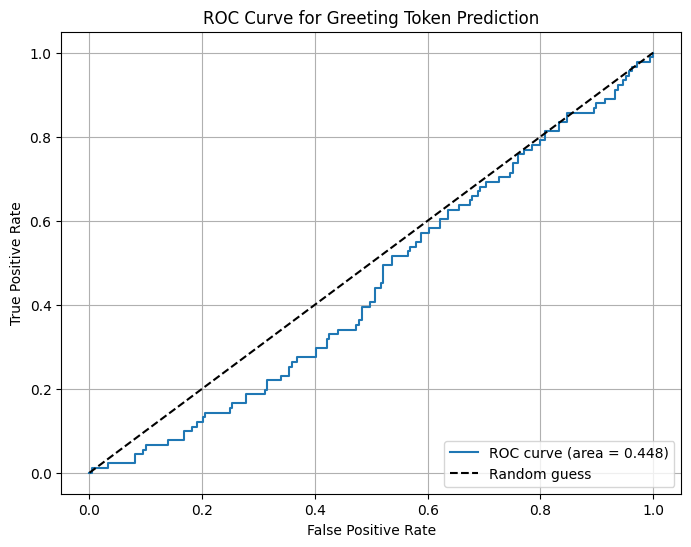

In [ ]:
# -------------------------------------
# Main Execution
# -------------------------------------
if __name__ == "__main__":
    trained_model, val_loader, seq_length = train_model()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    evaluate_roc_ks(trained_model, val_loader, seq_length, device)


In [ ]:
# Reminder: In Google Colab, go to Runtime > Change runtime type and select GPU.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# -------------------------------------
# Global Configuration (Modified)
# -------------------------------------
START_TOKEN = 1          # A special start token
VOCAB_SIZE = 300         # Reduced vocabulary size
D_MODEL = 128            # Transformer model dimension
NHEAD = 4
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2
DIM_FEEDFORWARD = 256
DROPOUT = 0.1
PREFIX_LEN = 5           # Learned prefix length
CUSTOMER_FEATURE_DIM = 15  # Updated to 15 features per customer

# -------------------------------------
# Positional Encoding Module
# -------------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=DROPOUT, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch, seq_len, d_model)
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# -------------------------------------
# Customer Feature Encoder (with Normalization and Learned Prompt)
# -------------------------------------
class CustomerFeatureEncoder(nn.Module):
    def __init__(self, input_dim, d_model, prefix_len=PREFIX_LEN):
        super(CustomerFeatureEncoder, self).__init__()
        self.norm = nn.LayerNorm(input_dim)
        self.fc = nn.Linear(input_dim, prefix_len * d_model)
        self.prefix_len = prefix_len

    def forward(self, customer_features):
        # customer_features: (batch, input_dim)
        x = self.norm(customer_features)
        out = self.fc(x)  # (batch, prefix_len * d_model)
        out = out.view(customer_features.size(0), self.prefix_len, -1)  # (batch, prefix_len, d_model)
        return out

# -------------------------------------
# Transformer-based Personalized NLG Model (Decoder-only part)
# -------------------------------------
class TransformerNLGModel(nn.Module):
    def __init__(self, vocab_size, d_model=D_MODEL, nhead=NHEAD, num_layers=NUM_DECODER_LAYERS,
                 dim_feedforward=DIM_FEEDFORWARD, dropout=DROPOUT):
        super(TransformerNLGModel, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)

        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)

        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        # tgt: (batch, seq_len)
        tgt_emb = self.token_embedding(tgt)         # (batch, seq_len, d_model)
        tgt_emb = self.positional_encoding(tgt_emb)   # (batch, seq_len, d_model)
        tgt_emb = tgt_emb.transpose(0, 1)             # (seq_len, batch, d_model)
        memory = memory.transpose(0, 1)               # (mem_len, batch, d_model)

        decoder_output = self.transformer_decoder(tgt_emb, memory,
                                                  tgt_mask=tgt_mask,
                                                  memory_mask=memory_mask)
        decoder_output = decoder_output.transpose(0, 1)  # (batch, seq_len, d_model)
        logits = self.fc_out(decoder_output)             # (batch, seq_len, vocab_size)
        return logits

# -------------------------------------
# Complete Personalized NLG Model (Encoder-Decoder)
# -------------------------------------
class TransformerPersonalizedNLG(nn.Module):
    def __init__(self, vocab_size, customer_feature_dim, d_model=D_MODEL, nhead=NHEAD,
                 num_layers=NUM_DECODER_LAYERS, dim_feedforward=DIM_FEEDFORWARD, dropout=DROPOUT, prefix_len=PREFIX_LEN):
        super(TransformerPersonalizedNLG, self).__init__()
        self.customer_encoder = CustomerFeatureEncoder(customer_feature_dim, d_model, prefix_len)
        self.nlg_model = TransformerNLGModel(vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout)

    def forward(self, input_seq, customer_features, tgt_mask=None, memory_mask=None):
        # Obtain the prefix from customer features
        memory = self.customer_encoder(customer_features)  # (batch, PREFIX_LEN, d_model)
        logits = self.nlg_model(input_seq, memory, tgt_mask=tgt_mask, memory_mask=memory_mask)
        return logits

# -------------------------------------
# Synthetic Customer Dataset with 15 Features
# -------------------------------------
class SyntheticCustomerDataset(Dataset):
    def __init__(self, num_samples, seq_length, vocab_size):
        """
        Each sample consists of:
          - Customer features (15-dimensional):
            [Age, Income, Account Balance, Tenure, Credit Score,
             Number of Products, Risk Profile, Loyalty Score, Region, Gender,
             Marital Status, Number of Dependents, Employment Status,
             Education Level, Home Ownership]
          - Target message tokens (length = seq_length):
              * First token: greeting token — 200 if loyalty > 0.7, else 201.
              * Remaining tokens: derived from account balance.
        """
        self.num_samples = num_samples
        self.seq_length = seq_length  # Target sequence length (without START_TOKEN)
        self.vocab_size = vocab_size
        self.data = []

        for _ in range(num_samples):
            age = np.random.randint(18, 81)
            income = np.random.uniform(20000, 150000)
            account_balance = np.random.uniform(0, 100000)
            tenure = np.random.randint(1, 31)
            credit_score = np.random.randint(300, 851)
            num_products = np.random.randint(1, 6)
            risk_profile = np.random.choice([0, 1, 2])
            loyalty_score = np.random.uniform(0, 1)
            region = np.random.randint(0, 5)
            gender = np.random.choice([0, 1])
            # New features:
            marital_status = np.random.choice([0, 1])       # 0: single, 1: married
            num_dependents = np.random.randint(0, 6)          # 0 to 5 dependents
            employment_status = np.random.choice([0, 1, 2])   # 0: unemployed, 1: employed, 2: self-employed
            education_level = np.random.randint(1, 6)         # 1 to 5 (e.g., high school to doctorate)
            home_ownership = np.random.choice([0, 1])         # 0: no, 1: yes

            features = torch.tensor(
                [age, income, account_balance, tenure, credit_score,
                 num_products, risk_profile, loyalty_score, region, gender,
                 marital_status, num_dependents, employment_status, education_level, home_ownership],
                dtype=torch.float
            )

            # The greeting token remains based solely on loyalty_score.
            greeting_token = 200 if loyalty_score > 0.7 else 201
            base = int(account_balance / 1000) % (vocab_size - (seq_length - 1))
            account_tokens = [base + i for i in range(seq_length - 1)]
            target_seq = torch.tensor([greeting_token] + account_tokens, dtype=torch.long)

            self.data.append((features, target_seq))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

# -------------------------------------
# Training and Evaluation Loop
# -------------------------------------
def train_model():
    # Hyperparameters
    num_samples = 1500
    seq_length = 10              # Target sequence length (without START_TOKEN)
    customer_feature_dim = CUSTOMER_FEATURE_DIM    # Now 15 features
    batch_size = 32
    num_epochs = 300             # Increased epochs for further convergence
    learning_rate = 1e-3         # Lower learning rate for fine tuning

    dataset = SyntheticCustomerDataset(num_samples, seq_length, VOCAB_SIZE)

    train_size = int(0.8 * num_samples)
    val_size = num_samples - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransformerPersonalizedNLG(VOCAB_SIZE, customer_feature_dim).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print("Starting Training...\n")

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        total_tokens = 0
        correct_tokens = 0

        for customer_features, target_seq in train_loader:
            customer_features = customer_features.to(device)  # (batch, 15)
            target_seq = target_seq.to(device)                # (batch, seq_length)

            batch_size_curr = target_seq.size(0)
            # Prepare decoder input via teacher forcing: prepend START_TOKEN and drop last token.
            start_tokens = torch.full((batch_size_curr, 1), START_TOKEN, dtype=torch.long).to(device)
            input_seq = torch.cat([start_tokens, target_seq[:, :-1]], dim=1)  # (batch, seq_length)

            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)

            optimizer.zero_grad()
            logits = model(input_seq, customer_features, tgt_mask=tgt_mask)
            loss = loss_fn(logits.reshape(-1, VOCAB_SIZE), target_seq.reshape(-1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * batch_size_curr * seq_length
            total_tokens += batch_size_curr * seq_length
            predictions = logits.argmax(dim=-1)
            correct_tokens += (predictions == target_seq).sum().item()

        avg_loss = epoch_loss / total_tokens
        token_accuracy = correct_tokens / total_tokens * 100
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Token Accuracy: {token_accuracy:.2f}%")

    print("\nTraining completed.\n")
    return model, val_loader, seq_length

# -------------------------------------
# Evaluation: ROC and KS for Greeting Token
# -------------------------------------
def evaluate_roc_ks(model, val_loader, seq_length, device):
    """
    Evaluates ROC, AUC, and KS statistic on the greeting token (position 0).
    The true binary label is 1 if the greeting token is 200, 0 otherwise.
    The predicted score is the probability for token 200.
    """
    model.eval()
    all_true = []
    all_scores = []

    with torch.no_grad():
        for customer_features, target_seq in val_loader:
            customer_features = customer_features.to(device)
            target_seq = target_seq.to(device)  # (batch, seq_length)
            batch_size = target_seq.size(0)

            # Prepare input sequence using teacher forcing
            start_tokens = torch.full((batch_size, 1), START_TOKEN, dtype=torch.long).to(device)
            input_seq = torch.cat([start_tokens, target_seq[:, :-1]], dim=1)  # (batch, seq_length)

            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)
            logits = model(input_seq, customer_features, tgt_mask=tgt_mask)
            # Focus on the greeting token (first position)
            logits_greeting = logits[:, 0, :]  # (batch, VOCAB_SIZE)
            probs_greeting = torch.softmax(logits_greeting, dim=1)

            # Extract probability for token 200 (positive class)
            scores = probs_greeting[:, 200].cpu().numpy()
            true_labels = (target_seq[:, 0] == 200).cpu().numpy().astype(int)

            all_scores.extend(scores.tolist())
            all_true.extend(true_labels.tolist())

    all_true = np.array(all_true)
    all_scores = np.array(all_scores)

    fpr, tpr, thresholds = roc_curve(all_true, all_scores)
    roc_auc = auc(fpr, tpr)
    ks = np.max(np.abs(tpr - fpr))

    print(f"ROC AUC: {roc_auc:.3f}")
    print(f"KS Statistic: {ks:.3f}")

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Greeting Token Prediction')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()



Starting Training...

Epoch 10/300 - Loss: 0.4764, Token Accuracy: 87.21%
Epoch 20/300 - Loss: 0.4611, Token Accuracy: 87.26%
Epoch 30/300 - Loss: 0.4547, Token Accuracy: 87.22%
Epoch 40/300 - Loss: 0.4466, Token Accuracy: 87.44%
Epoch 50/300 - Loss: 0.4436, Token Accuracy: 87.38%
Epoch 60/300 - Loss: 0.4374, Token Accuracy: 87.49%
Epoch 70/300 - Loss: 0.4332, Token Accuracy: 87.43%
Epoch 80/300 - Loss: 0.4488, Token Accuracy: 87.31%
Epoch 90/300 - Loss: 0.4250, Token Accuracy: 87.48%
Epoch 100/300 - Loss: 0.4129, Token Accuracy: 87.65%
Epoch 110/300 - Loss: 0.3933, Token Accuracy: 87.90%
Epoch 120/300 - Loss: 0.3931, Token Accuracy: 87.82%
Epoch 130/300 - Loss: 0.4058, Token Accuracy: 87.76%
Epoch 140/300 - Loss: 0.3787, Token Accuracy: 87.91%
Epoch 150/300 - Loss: 0.3766, Token Accuracy: 87.98%
Epoch 160/300 - Loss: 0.3736, Token Accuracy: 88.03%
Epoch 170/300 - Loss: 0.3710, Token Accuracy: 88.04%
Epoch 180/300 - Loss: 0.3599, Token Accuracy: 88.11%
Epoch 190/300 - Loss: 0.3595, Tok

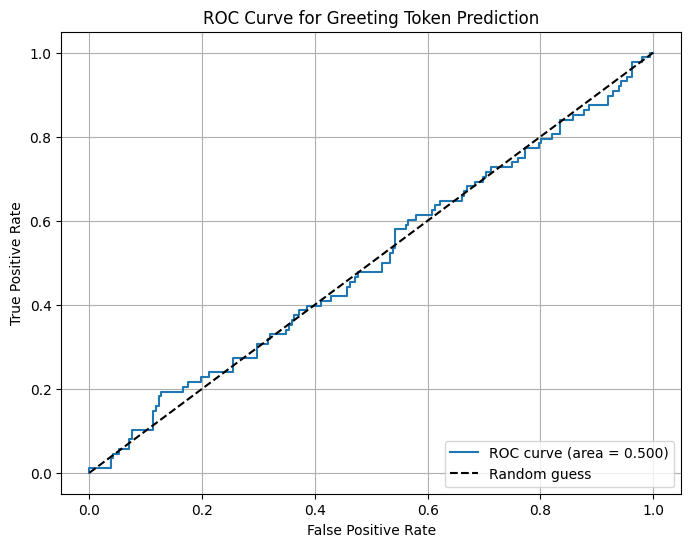

In [ ]:
# -------------------------------------
# Main Execution
# -------------------------------------
if __name__ == "__main__":
    trained_model, val_loader, seq_length = train_model()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    evaluate_roc_ks(trained_model, val_loader, seq_length, device)


In [ ]:
# Reminder: In Google Colab, go to Runtime > Change runtime type and select GPU.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# -------------------------------------
# Global Configuration (Modified)
# -------------------------------------
START_TOKEN = 1          # A special start token
VOCAB_SIZE = 300         # Reduced vocabulary size
D_MODEL = 128            # Transformer model dimension
NHEAD = 4
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2
DIM_FEEDFORWARD = 256
DROPOUT = 0.1
PREFIX_LEN = 5           # Learned prefix length
CUSTOMER_FEATURE_DIM = 15  # We already updated this for synthetic data with 15 features

# Weight for the auxiliary greeting loss
ALPHA = 1.0

# -------------------------------------
# Positional Encoding Module
# -------------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=DROPOUT, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch, seq_len, d_model)
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# -------------------------------------
# Customer Feature Encoder (with Normalization and Learned Prompt)
# -------------------------------------
class CustomerFeatureEncoder(nn.Module):
    def __init__(self, input_dim, d_model, prefix_len=PREFIX_LEN):
        super(CustomerFeatureEncoder, self).__init__()
        self.norm = nn.LayerNorm(input_dim)
        self.fc = nn.Linear(input_dim, prefix_len * d_model)
        self.prefix_len = prefix_len

    def forward(self, customer_features):
        # customer_features: (batch, input_dim)
        x = self.norm(customer_features)
        out = self.fc(x)  # (batch, prefix_len*d_model)
        out = out.view(customer_features.size(0), self.prefix_len, -1)  # (batch, prefix_len, d_model)
        return out

# -------------------------------------
# Transformer-based NLG Model (Decoder-only part)
# -------------------------------------
class TransformerNLGModel(nn.Module):
    def __init__(self, vocab_size, d_model=D_MODEL, nhead=NHEAD, num_layers=NUM_DECODER_LAYERS,
                 dim_feedforward=DIM_FEEDFORWARD, dropout=DROPOUT):
        super(TransformerNLGModel, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)

        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)

        self.fc_out = nn.Linear(d_model, vocab_size)
        # Auxiliary classifier for greeting token: maps the first token's hidden state to 2 classes.
        self.greeting_classifier = nn.Linear(d_model, 2)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        # tgt: (batch, seq_len)
        tgt_emb = self.token_embedding(tgt)         # (batch, seq_len, d_model)
        tgt_emb = self.positional_encoding(tgt_emb)   # (batch, seq_len, d_model)
        tgt_emb = tgt_emb.transpose(0, 1)             # (seq_len, batch, d_model)
        memory = memory.transpose(0, 1)               # (mem_len, batch, d_model)

        decoder_output = self.transformer_decoder(tgt_emb, memory,
                                                  tgt_mask=tgt_mask,
                                                  memory_mask=memory_mask)
        decoder_output = decoder_output.transpose(0, 1)  # (batch, seq_len, d_model)
        logits = self.fc_out(decoder_output)             # (batch, seq_len, vocab_size)
        # Extract the hidden state for the first token to classify the greeting.
        greeting_hidden = decoder_output[:, 0, :]  # (batch, d_model)
        greeting_logits = self.greeting_classifier(greeting_hidden)  # (batch, 2)
        return logits, greeting_logits

# -------------------------------------
# Complete Personalized NLG Model (Encoder-Decoder)
# -------------------------------------
class TransformerPersonalizedNLG(nn.Module):
    def __init__(self, vocab_size, customer_feature_dim, d_model=D_MODEL, nhead=NHEAD,
                 num_layers=NUM_DECODER_LAYERS, dim_feedforward=DIM_FEEDFORWARD, dropout=DROPOUT, prefix_len=PREFIX_LEN):
        super(TransformerPersonalizedNLG, self).__init__()
        self.customer_encoder = CustomerFeatureEncoder(customer_feature_dim, d_model, prefix_len)
        self.nlg_model = TransformerNLGModel(vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout)

    def forward(self, input_seq, customer_features, tgt_mask=None, memory_mask=None):
        # Obtain the prefix from customer features
        memory = self.customer_encoder(customer_features)  # (batch, PREFIX_LEN, d_model)
        logits, greeting_logits = self.nlg_model(input_seq, memory, tgt_mask=tgt_mask, memory_mask=memory_mask)
        return logits, greeting_logits

# -------------------------------------
# Synthetic Customer Dataset with 15 Features
# -------------------------------------
class SyntheticCustomerDataset(Dataset):
    def __init__(self, num_samples, seq_length, vocab_size):
        """
        Each sample consists of 15 customer features:
          [Age, Income, Account Balance, Tenure, Credit Score,
           Number of Products, Risk Profile, Loyalty Score, Region, Gender,
           Marital Status, Number of Dependents, Employment Status,
           Education Level, Home Ownership]
          And a target message tokens (length = seq_length):
              * First token: greeting token — 200 if loyalty > 0.7, else 201.
              * Remaining tokens: derived from account balance.
        """
        self.num_samples = num_samples
        self.seq_length = seq_length  # Target sequence length (without START_TOKEN)
        self.vocab_size = vocab_size
        self.data = []

        for _ in range(num_samples):
            age = np.random.randint(18, 81)
            income = np.random.uniform(20000, 150000)
            account_balance = np.random.uniform(0, 100000)
            tenure = np.random.randint(1, 31)
            credit_score = np.random.randint(300, 851)
            num_products = np.random.randint(1, 6)
            risk_profile = np.random.choice([0, 1, 2])
            loyalty_score = np.random.uniform(0, 1)
            region = np.random.randint(0, 5)
            gender = np.random.choice([0, 1])
            # New features:
            marital_status = np.random.choice([0, 1])       # 0: single, 1: married
            num_dependents = np.random.randint(0, 6)          # 0 to 5
            employment_status = np.random.choice([0, 1, 2])   # 0: unemployed, 1: employed, 2: self-employed
            education_level = np.random.randint(1, 6)         # 1 to 5
            home_ownership = np.random.choice([0, 1])         # 0: no, 1: yes

            features = torch.tensor(
                [age, income, account_balance, tenure, credit_score,
                 num_products, risk_profile, loyalty_score, region, gender,
                 marital_status, num_dependents, employment_status, education_level, home_ownership],
                dtype=torch.float
            )

            greeting_token = 200 if loyalty_score > 0.7 else 201
            base = int(account_balance / 1000) % (vocab_size - (seq_length - 1))
            account_tokens = [base + i for i in range(seq_length - 1)]
            target_seq = torch.tensor([greeting_token] + account_tokens, dtype=torch.long)

            self.data.append((features, target_seq))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

# -------------------------------------
# Training and Evaluation Loop
# -------------------------------------
def train_model():
    # Hyperparameters
    num_samples = 1500
    seq_length = 10              # Target sequence length (without START_TOKEN)
    customer_feature_dim = 15    # 15 customer features now
    batch_size = 32
    num_epochs = 300             # Increased epochs
    learning_rate = 1e-3         # Learning rate

    dataset = SyntheticCustomerDataset(num_samples, seq_length, VOCAB_SIZE)

    train_size = int(0.8 * num_samples)
    val_size = num_samples - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransformerPersonalizedNLG(VOCAB_SIZE, customer_feature_dim).to(device)
    loss_fn = nn.CrossEntropyLoss()
    aux_loss_fn = nn.CrossEntropyLoss()  # For auxiliary greeting token classification
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print("Starting Training...\n")

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        total_tokens = 0
        correct_tokens = 0
        aux_loss_epoch = 0.0
        num_batches = 0

        for customer_features, target_seq in train_loader:
            customer_features = customer_features.to(device)  # (batch, 15)
            target_seq = target_seq.to(device)                # (batch, seq_length)

            batch_size_curr = target_seq.size(0)
            # Prepare decoder input via teacher forcing: prepend START_TOKEN and drop last token.
            start_tokens = torch.full((batch_size_curr, 1), START_TOKEN, dtype=torch.long).to(device)
            input_seq = torch.cat([start_tokens, target_seq[:, :-1]], dim=1)  # (batch, seq_length)

            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)

            optimizer.zero_grad()
            logits, greeting_logits = model(input_seq, customer_features, tgt_mask=tgt_mask)
            # Primary loss: full sequence cross-entropy.
            loss = loss_fn(logits.reshape(-1, VOCAB_SIZE), target_seq.reshape(-1))
            # Auxiliary loss: classification loss on the greeting token.
            # True label: 1 if target greeting is 200, else 0.
            true_greeting = (target_seq[:, 0] == 200).long()  # shape: (batch,)
            aux_loss = aux_loss_fn(greeting_logits, true_greeting)

            total_loss = loss + ALPHA * aux_loss
            total_loss.backward()
            optimizer.step()

            epoch_loss += total_loss.item() * batch_size_curr * seq_length
            total_tokens += batch_size_curr * seq_length
            aux_loss_epoch += aux_loss.item() * batch_size_curr
            predictions = logits.argmax(dim=-1)
            correct_tokens += (predictions == target_seq).sum().item()
            num_batches += 1

        avg_loss = epoch_loss / total_tokens
        token_accuracy = correct_tokens / total_tokens * 100
        avg_aux_loss = aux_loss_epoch / (batch_size * num_batches)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Aux Loss: {avg_aux_loss:.4f}, Token Accuracy: {token_accuracy:.2f}%")

    print("\nTraining completed.\n")
    return model, val_loader, seq_length

# -------------------------------------
# Evaluation: ROC and KS for Greeting Token
# -------------------------------------
def evaluate_roc_ks(model, val_loader, seq_length, device):
    """
    Evaluates ROC, AUC, and KS statistic on the greeting token (position 0).
    True binary label is 1 if the greeting token is 200, 0 otherwise.
    Predicted score is the probability for token 200.
    """
    model.eval()
    all_true = []
    all_scores = []

    with torch.no_grad():
        for customer_features, target_seq in val_loader:
            customer_features = customer_features.to(device)
            target_seq = target_seq.to(device)  # (batch, seq_length)
            batch_size = target_seq.size(0)

            start_tokens = torch.full((batch_size, 1), START_TOKEN, dtype=torch.long).to(device)
            input_seq = torch.cat([start_tokens, target_seq[:, :-1]], dim=1)  # (batch, seq_length)

            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)
            logits, greeting_logits = model(input_seq, customer_features, tgt_mask=tgt_mask)
            # Instead of using logits from the sequence, use the auxiliary greeting_logits.
            # Apply softmax on the auxiliary output.
            probs = torch.softmax(greeting_logits, dim=1)
            scores = probs[:, 1].cpu().numpy()  # Let index 1 correspond to positive class (token 200)
            true_labels = (target_seq[:, 0] == 200).cpu().numpy().astype(int)

            all_scores.extend(scores.tolist())
            all_true.extend(true_labels.tolist())

    all_true = np.array(all_true)
    all_scores = np.array(all_scores)

    fpr, tpr, thresholds = roc_curve(all_true, all_scores)
    roc_auc = auc(fpr, tpr)
    ks = np.max(np.abs(tpr - fpr))

    print(f"ROC AUC: {roc_auc:.3f}")
    print(f"KS Statistic: {ks:.3f}")

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Greeting Token Prediction')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()



Starting Training...

Epoch 10/300 - Loss: 1.1097, Aux Loss: 0.6188, Token Accuracy: 87.32%
Epoch 20/300 - Loss: 1.0877, Aux Loss: 0.6139, Token Accuracy: 87.31%
Epoch 30/300 - Loss: 1.0782, Aux Loss: 0.6130, Token Accuracy: 87.46%
Epoch 40/300 - Loss: 1.0725, Aux Loss: 0.6129, Token Accuracy: 87.50%
Epoch 50/300 - Loss: 1.0709, Aux Loss: 0.6153, Token Accuracy: 87.43%
Epoch 60/300 - Loss: 1.0581, Aux Loss: 0.6115, Token Accuracy: 87.59%
Epoch 70/300 - Loss: 1.0638, Aux Loss: 0.6152, Token Accuracy: 87.45%
Epoch 80/300 - Loss: 1.0514, Aux Loss: 0.6111, Token Accuracy: 87.45%
Epoch 90/300 - Loss: 1.0464, Aux Loss: 0.6101, Token Accuracy: 87.63%
Epoch 100/300 - Loss: 1.0368, Aux Loss: 0.6112, Token Accuracy: 87.60%
Epoch 110/300 - Loss: 1.0307, Aux Loss: 0.6120, Token Accuracy: 87.83%
Epoch 120/300 - Loss: 1.0171, Aux Loss: 0.6110, Token Accuracy: 87.90%
Epoch 130/300 - Loss: 1.0126, Aux Loss: 0.6139, Token Accuracy: 87.92%
Epoch 140/300 - Loss: 1.0025, Aux Loss: 0.6117, Token Accuracy: 

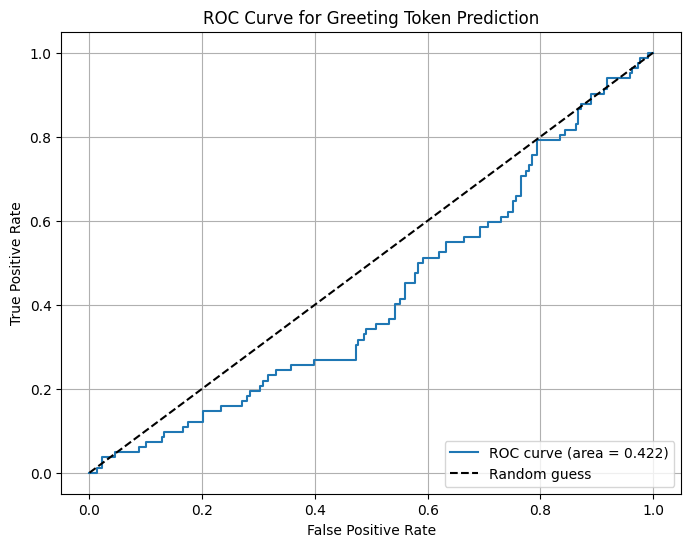

In [ ]:
# -------------------------------------
# Main Execution
# -------------------------------------
if __name__ == "__main__":
    trained_model, val_loader, seq_length = train_model()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    evaluate_roc_ks(trained_model, val_loader, seq_length, device)


In [ ]:
# Reminder: In Google Colab, go to Runtime > Change runtime type and select GPU.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# -------------------------------------
# Global Configuration (Modified)
# -------------------------------------
START_TOKEN = 1          # A special start token
VOCAB_SIZE = 300         # Reduced vocabulary size
D_MODEL = 128            # Transformer model dimension
NHEAD = 4
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2
DIM_FEEDFORWARD = 256
DROPOUT = 0.1
PREFIX_LEN = 5           # Learned prefix length
CUSTOMER_FEATURE_DIM = 15  # 15 customer features

# Auxiliary loss weight for the greeting token classifier
ALPHA = 3.0

# Class weights for the auxiliary greeting classifier.
# Assuming roughly 30% positive (token 200) and 70% negative (token 201)
# Weight higher for the minority class (positive).
CLASS_WEIGHTS = torch.tensor([1.0, 2.5])

# -------------------------------------
# Positional Encoding Module
# -------------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=DROPOUT, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch, seq_len, d_model)
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# -------------------------------------
# Customer Feature Encoder (with Normalization and Learned Prompt)
# -------------------------------------
class CustomerFeatureEncoder(nn.Module):
    def __init__(self, input_dim, d_model, prefix_len=PREFIX_LEN):
        super(CustomerFeatureEncoder, self).__init__()
        self.norm = nn.LayerNorm(input_dim)
        self.fc = nn.Linear(input_dim, prefix_len * d_model)
        self.prefix_len = prefix_len

    def forward(self, customer_features):
        # customer_features: (batch, input_dim)
        x = self.norm(customer_features)
        out = self.fc(x)  # (batch, prefix_len*d_model)
        out = out.view(customer_features.size(0), self.prefix_len, -1)  # (batch, prefix_len, d_model)
        return out

# -------------------------------------
# Transformer-based NLG Model (Decoder-only part with Auxiliary Classifier)
# -------------------------------------
class TransformerNLGModel(nn.Module):
    def __init__(self, vocab_size, d_model=D_MODEL, nhead=NHEAD, num_layers=NUM_DECODER_LAYERS,
                 dim_feedforward=DIM_FEEDFORWARD, dropout=DROPOUT):
        super(TransformerNLGModel, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)

        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)

        self.fc_out = nn.Linear(d_model, vocab_size)
        # Auxiliary classifier for the greeting token (first token)
        self.greeting_classifier = nn.Linear(d_model, 2)  # 2 classes: 0 for token 201, 1 for token 200

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        # tgt: (batch, seq_len)
        tgt_emb = self.token_embedding(tgt)         # (batch, seq_len, d_model)
        tgt_emb = self.positional_encoding(tgt_emb)   # (batch, seq_len, d_model)
        tgt_emb = tgt_emb.transpose(0, 1)             # (seq_len, batch, d_model)
        memory = memory.transpose(0, 1)               # (mem_len, batch, d_model)

        decoder_output = self.transformer_decoder(tgt_emb, memory,
                                                  tgt_mask=tgt_mask,
                                                  memory_mask=memory_mask)
        decoder_output = decoder_output.transpose(0, 1)  # (batch, seq_len, d_model)
        logits = self.fc_out(decoder_output)             # (batch, seq_len, vocab_size)
        # Auxiliary: use the hidden state of the first token for greeting classification.
        greeting_hidden = decoder_output[:, 0, :]  # (batch, d_model)
        greeting_logits = self.greeting_classifier(greeting_hidden)  # (batch, 2)
        return logits, greeting_logits

# -------------------------------------
# Complete Personalized NLG Model (Encoder-Decoder)
# -------------------------------------
class TransformerPersonalizedNLG(nn.Module):
    def __init__(self, vocab_size, customer_feature_dim, d_model=D_MODEL, nhead=NHEAD,
                 num_layers=NUM_DECODER_LAYERS, dim_feedforward=DIM_FEEDFORWARD, dropout=DROPOUT, prefix_len=PREFIX_LEN):
        super(TransformerPersonalizedNLG, self).__init__()
        self.customer_encoder = CustomerFeatureEncoder(customer_feature_dim, d_model, prefix_len)
        self.nlg_model = TransformerNLGModel(vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout)

    def forward(self, input_seq, customer_features, tgt_mask=None, memory_mask=None):
        # Obtain the prefix from customer features
        memory = self.customer_encoder(customer_features)  # (batch, PREFIX_LEN, d_model)
        logits, greeting_logits = self.nlg_model(input_seq, memory, tgt_mask=tgt_mask, memory_mask=memory_mask)
        return logits, greeting_logits

# -------------------------------------
# Synthetic Customer Dataset with 15 Features
# -------------------------------------
class SyntheticCustomerDataset(Dataset):
    def __init__(self, num_samples, seq_length, vocab_size):
        """
        Each sample consists of 15 customer features:
          [Age, Income, Account Balance, Tenure, Credit Score,
           Number of Products, Risk Profile, Loyalty Score, Region, Gender,
           Marital Status, Number of Dependents, Employment Status,
           Education Level, Home Ownership]
        And a target message tokens (length = seq_length):
              * First token: greeting token — 200 if loyalty > 0.7, else 201.
              * Remaining tokens: derived from account balance.
        """
        self.num_samples = num_samples
        self.seq_length = seq_length  # Target sequence length (without START_TOKEN)
        self.vocab_size = vocab_size
        self.data = []

        for _ in range(num_samples):
            age = np.random.randint(18, 81)
            income = np.random.uniform(20000, 150000)
            account_balance = np.random.uniform(0, 100000)
            tenure = np.random.randint(1, 31)
            credit_score = np.random.randint(300, 851)
            num_products = np.random.randint(1, 6)
            risk_profile = np.random.choice([0, 1, 2])
            loyalty_score = np.random.uniform(0, 1)
            region = np.random.randint(0, 5)
            gender = np.random.choice([0, 1])
            # New features:
            marital_status = np.random.choice([0, 1])       # 0: single, 1: married
            num_dependents = np.random.randint(0, 6)          # 0 to 5 dependents
            employment_status = np.random.choice([0, 1, 2])   # 0: unemployed, 1: employed, 2: self-employed
            education_level = np.random.randint(1, 6)         # 1 to 5 (e.g., 1: high school, 5: doctorate)
            home_ownership = np.random.choice([0, 1])         # 0: no, 1: yes

            features = torch.tensor(
                [age, income, account_balance, tenure, credit_score,
                 num_products, risk_profile, loyalty_score, region, gender,
                 marital_status, num_dependents, employment_status, education_level, home_ownership],
                dtype=torch.float
            )

            # Greeting token is based solely on loyalty_score
            greeting_token = 200 if loyalty_score > 0.7 else 201
            base = int(account_balance / 1000) % (vocab_size - (seq_length - 1))
            account_tokens = [base + i for i in range(seq_length - 1)]
            target_seq = torch.tensor([greeting_token] + account_tokens, dtype=torch.long)

            self.data.append((features, target_seq))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

# -------------------------------------
# Training and Evaluation Loop
# -------------------------------------
def train_model():
    # Hyperparameters
    num_samples = 1500
    seq_length = 10              # Target sequence length (without START_TOKEN)
    customer_feature_dim = CUSTOMER_FEATURE_DIM    # 15 customer features
    batch_size = 32
    num_epochs = 300             # Increased epochs for further convergence
    learning_rate = 1e-3         # Learning rate

    dataset = SyntheticCustomerDataset(num_samples, seq_length, VOCAB_SIZE)

    train_size = int(0.8 * num_samples)
    val_size = num_samples - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransformerPersonalizedNLG(VOCAB_SIZE, customer_feature_dim).to(device)
    loss_fn = nn.CrossEntropyLoss()
    # Set auxiliary loss function with class weighting for greeting token classifier.
    aux_loss_fn = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS.to(device))
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print("Starting Training...\n")

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        total_tokens = 0
        correct_tokens = 0
        aux_loss_epoch = 0.0
        num_batches = 0

        for customer_features, target_seq in train_loader:
            customer_features = customer_features.to(device)  # (batch, 15)
            target_seq = target_seq.to(device)                # (batch, seq_length)

            batch_size_curr = target_seq.size(0)
            # Prepare decoder input via teacher forcing: prepend START_TOKEN and drop last token.
            start_tokens = torch.full((batch_size_curr, 1), START_TOKEN, dtype=torch.long).to(device)
            input_seq = torch.cat([start_tokens, target_seq[:, :-1]], dim=1)  # (batch, seq_length)

            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)

            optimizer.zero_grad()
            logits, greeting_logits = model(input_seq, customer_features, tgt_mask=tgt_mask)
            # Primary sequence loss over the full output.
            loss = loss_fn(logits.reshape(-1, VOCAB_SIZE), target_seq.reshape(-1))
            # Auxiliary loss on the greeting token:
            true_greeting = (target_seq[:, 0] == 200).long()  # 1 if token is 200, else 0.
            aux_loss = aux_loss_fn(greeting_logits, true_greeting)

            total_loss = loss + ALPHA * aux_loss
            total_loss.backward()
            optimizer.step()

            epoch_loss += total_loss.item() * batch_size_curr * seq_length
            total_tokens += batch_size_curr * seq_length
            aux_loss_epoch += aux_loss.item() * batch_size_curr
            predictions = logits.argmax(dim=-1)
            correct_tokens += (predictions == target_seq).sum().item()
            num_batches += 1

        avg_loss = epoch_loss / total_tokens
        token_accuracy = correct_tokens / total_tokens * 100
        avg_aux_loss = aux_loss_epoch / (batch_size * num_batches)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Aux Loss: {avg_aux_loss:.4f}, Token Accuracy: {token_accuracy:.2f}%")

    print("\nTraining completed.\n")
    return model, val_loader, seq_length

# -------------------------------------
# Evaluation: ROC and KS for Greeting Token
# -------------------------------------
def evaluate_roc_ks(model, val_loader, seq_length, device):
    """
    Evaluates ROC, AUC, and KS statistic on the greeting token (position 0).
    True binary label is 1 if greeting token is 200, 0 otherwise.
    Predicted score is the probability (from the auxiliary classifier) for class 1.
    """
    model.eval()
    all_true = []
    all_scores = []

    with torch.no_grad():
        for customer_features, target_seq in val_loader:
            customer_features = customer_features.to(device)
            target_seq = target_seq.to(device)  # (batch, seq_length)
            batch_size = target_seq.size(0)

            start_tokens = torch.full((batch_size, 1), START_TOKEN, dtype=torch.long).to(device)
            input_seq = torch.cat([start_tokens, target_seq[:, :-1]], dim=1)  # (batch, seq_length)

            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)
            _, greeting_logits = model(input_seq, customer_features, tgt_mask=tgt_mask)
            probs = torch.softmax(greeting_logits, dim=1)  # (batch, 2)
            scores = probs[:, 1].cpu().numpy()  # Probability for class 1 (token 200)
            true_labels = (target_seq[:, 0] == 200).cpu().numpy().astype(int)

            all_scores.extend(scores.tolist())
            all_true.extend(true_labels.tolist())

    all_true = np.array(all_true)
    all_scores = np.array(all_scores)

    fpr, tpr, thresholds = roc_curve(all_true, all_scores)
    roc_auc = auc(fpr, tpr)
    ks = np.max(np.abs(tpr - fpr))

    print(f"ROC AUC: {roc_auc:.3f}")
    print(f"KS Statistic: {ks:.3f}")

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Greeting Token Prediction')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()



Starting Training...

Epoch 10/300 - Loss: 2.5590, Aux Loss: 0.6819, Token Accuracy: 86.92%
Epoch 20/300 - Loss: 2.5363, Aux Loss: 0.6808, Token Accuracy: 86.90%
Epoch 30/300 - Loss: 2.5115, Aux Loss: 0.6762, Token Accuracy: 87.02%
Epoch 40/300 - Loss: 2.5112, Aux Loss: 0.6780, Token Accuracy: 87.11%
Epoch 50/300 - Loss: 2.5190, Aux Loss: 0.6815, Token Accuracy: 86.98%
Epoch 60/300 - Loss: 2.5016, Aux Loss: 0.6767, Token Accuracy: 87.11%
Epoch 70/300 - Loss: 2.5051, Aux Loss: 0.6788, Token Accuracy: 87.14%
Epoch 80/300 - Loss: 2.4921, Aux Loss: 0.6773, Token Accuracy: 87.19%
Epoch 90/300 - Loss: 2.4903, Aux Loss: 0.6778, Token Accuracy: 87.23%
Epoch 100/300 - Loss: 2.4824, Aux Loss: 0.6758, Token Accuracy: 87.17%
Epoch 110/300 - Loss: 2.4809, Aux Loss: 0.6765, Token Accuracy: 87.16%
Epoch 120/300 - Loss: 2.4961, Aux Loss: 0.6796, Token Accuracy: 87.15%
Epoch 130/300 - Loss: 2.4770, Aux Loss: 0.6766, Token Accuracy: 87.32%
Epoch 140/300 - Loss: 2.4670, Aux Loss: 0.6783, Token Accuracy: 

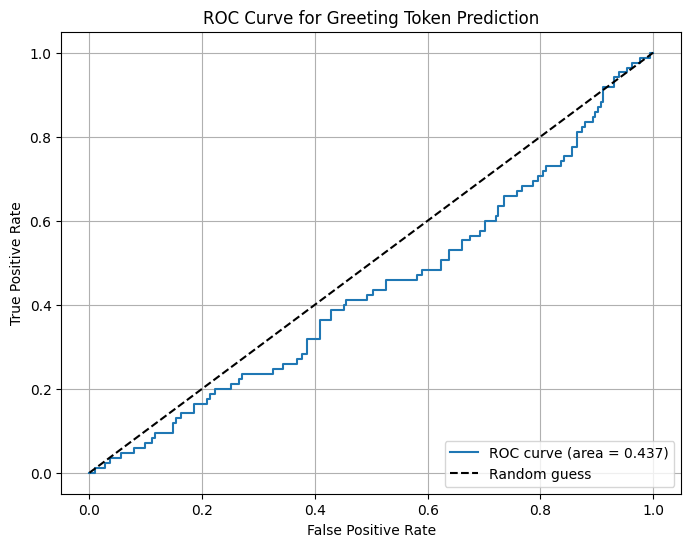

In [ ]:
# -------------------------------------
# Main Execution
# -------------------------------------
if __name__ == "__main__":
    trained_model, val_loader, seq_length = train_model()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    evaluate_roc_ks(trained_model, val_loader, seq_length, device)


In [ ]:
# Reminder: In Google Colab, go to Runtime > Change runtime type and select GPU.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# -------------------------------------
# Global Configuration (Modified)
# -------------------------------------
START_TOKEN = 1          # A special start token
VOCAB_SIZE = 300         # Reduced vocabulary size
D_MODEL = 128            # Transformer model dimension
NHEAD = 4
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2
DIM_FEEDFORWARD = 256
DROPOUT = 0.1
PREFIX_LEN = 5           # Learned prefix length
CUSTOMER_FEATURE_DIM = 15  # 15 customer features

# Auxiliary loss weight for the greeting token classifier
ALPHA = 10.0

# Class weights for the auxiliary greeting classifier.
# (0 corresponds to token 201, 1 corresponds to token 200)
CLASS_WEIGHTS = torch.tensor([1.0, 5.0])

# -------------------------------------
# Positional Encoding Module
# -------------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=DROPOUT, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch, seq_len, d_model)
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# -------------------------------------
# Customer Feature Encoder (with Normalization and Learned Prompt)
# -------------------------------------
class CustomerFeatureEncoder(nn.Module):
    def __init__(self, input_dim, d_model, prefix_len=PREFIX_LEN):
        super(CustomerFeatureEncoder, self).__init__()
        self.norm = nn.LayerNorm(input_dim)
        self.fc = nn.Linear(input_dim, prefix_len * d_model)
        self.prefix_len = prefix_len

    def forward(self, customer_features):
        # customer_features: (batch, input_dim)
        x = self.norm(customer_features)
        out = self.fc(x)  # (batch, prefix_len*d_model)
        out = out.view(customer_features.size(0), self.prefix_len, -1)  # (batch, prefix_len, d_model)
        return out

# -------------------------------------
# Transformer-based NLG Model (Decoder-only part with Enhanced Greeting Classifier)
# -------------------------------------
class TransformerNLGModel(nn.Module):
    def __init__(self, vocab_size, d_model=D_MODEL, nhead=NHEAD, num_layers=NUM_DECODER_LAYERS,
                 dim_feedforward=DIM_FEEDFORWARD, dropout=DROPOUT):
        super(TransformerNLGModel, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)

        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)

        self.fc_out = nn.Linear(d_model, vocab_size)
        # Enhanced auxiliary classifier for greeting token using an MLP.
        self.greeting_classifier = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, 2)
        )

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        # tgt: (batch, seq_len)
        tgt_emb = self.token_embedding(tgt)         # (batch, seq_len, d_model)
        tgt_emb = self.positional_encoding(tgt_emb)   # (batch, seq_len, d_model)
        tgt_emb = tgt_emb.transpose(0, 1)             # (seq_len, batch, d_model)
        memory = memory.transpose(0, 1)               # (mem_len, batch, d_model)

        decoder_output = self.transformer_decoder(tgt_emb, memory,
                                                  tgt_mask=tgt_mask,
                                                  memory_mask=memory_mask)
        decoder_output = decoder_output.transpose(0, 1)  # (batch, seq_len, d_model)
        logits = self.fc_out(decoder_output)             # (batch, seq_len, vocab_size)
        # Use the hidden state of the first token for greeting classification.
        greeting_hidden = decoder_output[:, 0, :]  # (batch, d_model)
        greeting_logits = self.greeting_classifier(greeting_hidden)  # (batch, 2)
        return logits, greeting_logits

# -------------------------------------
# Complete Personalized NLG Model (Encoder-Decoder)
# -------------------------------------
class TransformerPersonalizedNLG(nn.Module):
    def __init__(self, vocab_size, customer_feature_dim, d_model=D_MODEL, nhead=NHEAD,
                 num_layers=NUM_DECODER_LAYERS, dim_feedforward=DIM_FEEDFORWARD, dropout=DROPOUT, prefix_len=PREFIX_LEN):
        super(TransformerPersonalizedNLG, self).__init__()
        self.customer_encoder = CustomerFeatureEncoder(customer_feature_dim, d_model, prefix_len)
        self.nlg_model = TransformerNLGModel(vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout)

    def forward(self, input_seq, customer_features, tgt_mask=None, memory_mask=None):
        # Obtain the prefix from customer features.
        memory = self.customer_encoder(customer_features)  # (batch, PREFIX_LEN, d_model)
        logits, greeting_logits = self.nlg_model(input_seq, memory, tgt_mask=tgt_mask, memory_mask=memory_mask)
        return logits, greeting_logits

# -------------------------------------
# Synthetic Customer Dataset with 15 Features
# -------------------------------------
class SyntheticCustomerDataset(Dataset):
    def __init__(self, num_samples, seq_length, vocab_size):
        """
        Each sample consists of 15 customer features:
          [Age, Income, Account Balance, Tenure, Credit Score,
           Number of Products, Risk Profile, Loyalty Score, Region, Gender,
           Marital Status, Number of Dependents, Employment Status,
           Education Level, Home Ownership]
        And a target message tokens (length = seq_length):
              * First token: greeting token — 200 if loyalty > 0.7, else 201.
              * Remaining tokens: derived from account balance.
        """
        self.num_samples = num_samples
        self.seq_length = seq_length  # Target sequence length (without START_TOKEN)
        self.vocab_size = vocab_size
        self.data = []

        for _ in range(num_samples):
            age = np.random.randint(18, 81)
            income = np.random.uniform(20000, 150000)
            account_balance = np.random.uniform(0, 100000)
            tenure = np.random.randint(1, 31)
            credit_score = np.random.randint(300, 851)
            num_products = np.random.randint(1, 6)
            risk_profile = np.random.choice([0, 1, 2])
            loyalty_score = np.random.uniform(0, 1)
            region = np.random.randint(0, 5)
            gender = np.random.choice([0, 1])
            # New features:
            marital_status = np.random.choice([0, 1])       # 0: single, 1: married
            num_dependents = np.random.randint(0, 6)          # 0 to 5 dependents
            employment_status = np.random.choice([0, 1, 2])   # 0: unemployed, 1: employed, 2: self-employed
            education_level = np.random.randint(1, 6)         # 1 to 5 (e.g., high school to doctorate)
            home_ownership = np.random.choice([0, 1])         # 0: no, 1: yes

            features = torch.tensor(
                [age, income, account_balance, tenure, credit_score,
                 num_products, risk_profile, loyalty_score, region, gender,
                 marital_status, num_dependents, employment_status, education_level, home_ownership],
                dtype=torch.float
            )

            # Greeting token is based solely on loyalty_score.
            greeting_token = 200 if loyalty_score > 0.7 else 201
            base = int(account_balance / 1000) % (vocab_size - (seq_length - 1))
            account_tokens = [base + i for i in range(seq_length - 1)]
            target_seq = torch.tensor([greeting_token] + account_tokens, dtype=torch.long)

            self.data.append((features, target_seq))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

# -------------------------------------
# Training and Evaluation Loop
# -------------------------------------
def train_model():
    # Hyperparameters
    num_samples = 1500
    seq_length = 10              # Target sequence length (without START_TOKEN)
    customer_feature_dim = CUSTOMER_FEATURE_DIM  # 15 customer features
    batch_size = 32
    num_epochs = 300             # Number of epochs
    learning_rate = 1e-3         # Learning rate

    dataset = SyntheticCustomerDataset(num_samples, seq_length, VOCAB_SIZE)

    train_size = int(0.8 * num_samples)
    val_size = num_samples - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransformerPersonalizedNLG(VOCAB_SIZE, customer_feature_dim).to(device)
    loss_fn = nn.CrossEntropyLoss()
    aux_loss_fn = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS.to(device))
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print("Starting Training...\n")

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        total_tokens = 0
        correct_tokens = 0
        aux_loss_epoch = 0.0
        num_batches = 0

        for customer_features, target_seq in train_loader:
            customer_features = customer_features.to(device)  # (batch, 15)
            target_seq = target_seq.to(device)                # (batch, seq_length)

            batch_size_curr = target_seq.size(0)
            # Teacher forcing: prepend START_TOKEN and drop last token.
            start_tokens = torch.full((batch_size_curr, 1), START_TOKEN, dtype=torch.long).to(device)
            input_seq = torch.cat([start_tokens, target_seq[:, :-1]], dim=1)  # (batch, seq_length)

            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)

            optimizer.zero_grad()
            logits, greeting_logits = model(input_seq, customer_features, tgt_mask=tgt_mask)
            # Primary sequence loss
            loss = loss_fn(logits.reshape(-1, VOCAB_SIZE), target_seq.reshape(-1))
            # Auxiliary loss on greeting token
            true_greeting = (target_seq[:, 0] == 200).long()  # (batch,)
            aux_loss = aux_loss_fn(greeting_logits, true_greeting)

            total_loss = loss + ALPHA * aux_loss
            total_loss.backward()
            optimizer.step()

            epoch_loss += total_loss.item() * batch_size_curr * seq_length
            total_tokens += batch_size_curr * seq_length
            aux_loss_epoch += aux_loss.item() * batch_size_curr
            predictions = logits.argmax(dim=-1)
            correct_tokens += (predictions == target_seq).sum().item()
            num_batches += 1

        avg_loss = epoch_loss / total_tokens
        token_accuracy = correct_tokens / total_tokens * 100
        avg_aux_loss = aux_loss_epoch / (batch_size * num_batches)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Aux Loss: {avg_aux_loss:.4f}, Token Accuracy: {token_accuracy:.2f}%")

    print("\nTraining completed.\n")
    return model, val_loader, seq_length

# -------------------------------------
# Evaluation: ROC and KS for Greeting Token
# -------------------------------------
def evaluate_roc_ks(model, val_loader, seq_length, device):
    """
    Evaluates ROC, AUC, and KS statistic on the greeting token (position 0).
    True binary label is 1 if the greeting token is 200, 0 otherwise.
    Predicted score is the probability (from the auxiliary classifier) for class 1.
    """
    model.eval()
    all_true = []
    all_scores = []

    with torch.no_grad():
        for customer_features, target_seq in val_loader:
            customer_features = customer_features.to(device)
            target_seq = target_seq.to(device)  # (batch, seq_length)
            batch_size = target_seq.size(0)

            start_tokens = torch.full((batch_size, 1), START_TOKEN, dtype=torch.long).to(device)
            input_seq = torch.cat([start_tokens, target_seq[:, :-1]], dim=1)  # (batch, seq_length)

            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)
            _, greeting_logits = model(input_seq, customer_features, tgt_mask=tgt_mask)
            probs = torch.softmax(greeting_logits, dim=1)  # (batch, 2)
            scores = probs[:, 1].cpu().numpy()  # Probability for class 1 (token 200)
            true_labels = (target_seq[:, 0] == 200).cpu().numpy().astype(int)

            all_scores.extend(scores.tolist())
            all_true.extend(true_labels.tolist())

    all_true = np.array(all_true)
    all_scores = np.array(all_scores)

    fpr, tpr, thresholds = roc_curve(all_true, all_scores)
    roc_auc = auc(fpr, tpr)
    ks = np.max(np.abs(tpr - fpr))

    print(f"ROC AUC: {roc_auc:.3f}")
    print(f"KS Statistic: {ks:.3f}")

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Greeting Token Prediction')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


Starting Training...

Epoch 10/300 - Loss: 6.8808, Aux Loss: 0.6309, Token Accuracy: 87.35%
Epoch 20/300 - Loss: 6.8143, Aux Loss: 0.6261, Token Accuracy: 87.31%
Epoch 30/300 - Loss: 6.8685, Aux Loss: 0.6314, Token Accuracy: 87.34%
Epoch 40/300 - Loss: 6.8310, Aux Loss: 0.6287, Token Accuracy: 87.50%
Epoch 50/300 - Loss: 6.8020, Aux Loss: 0.6267, Token Accuracy: 87.61%
Epoch 60/300 - Loss: 6.8208, Aux Loss: 0.6292, Token Accuracy: 87.64%
Epoch 70/300 - Loss: 6.7988, Aux Loss: 0.6273, Token Accuracy: 87.58%
Epoch 80/300 - Loss: 6.7972, Aux Loss: 0.6270, Token Accuracy: 87.64%
Epoch 90/300 - Loss: 6.8296, Aux Loss: 0.6311, Token Accuracy: 87.65%
Epoch 100/300 - Loss: 6.7931, Aux Loss: 0.6276, Token Accuracy: 87.59%
Epoch 110/300 - Loss: 6.7875, Aux Loss: 0.6271, Token Accuracy: 87.61%
Epoch 120/300 - Loss: 6.8325, Aux Loss: 0.6324, Token Accuracy: 87.65%
Epoch 130/300 - Loss: 6.7713, Aux Loss: 0.6272, Token Accuracy: 87.72%
Epoch 140/300 - Loss: 6.8139, Aux Loss: 0.6325, Token Accuracy: 

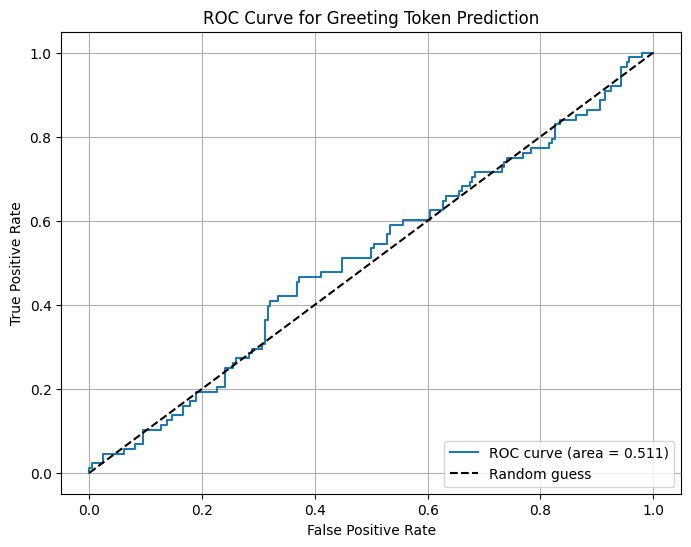

In [ ]:

# -------------------------------------
# Main Execution
# -------------------------------------
if __name__ == "__main__":
    trained_model, val_loader, seq_length = train_model()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    evaluate_roc_ks(trained_model, val_loader, seq_length, device)


In [ ]:
# Reminder: In Google Colab, go to Runtime > Change runtime type and select GPU.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# -------------------------------------
# Global Configuration (Modified)
# -------------------------------------
START_TOKEN = 1          # A special start token
VOCAB_SIZE = 300         # Reduced vocabulary size
D_MODEL = 128            # Transformer model dimension
NHEAD = 4
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2
DIM_FEEDFORWARD = 256
DROPOUT = 0.1
PREFIX_LEN = 5           # Learned prefix length
CUSTOMER_FEATURE_DIM = 15  # 15 customer features

# Auxiliary loss weight for the greeting token classifier
ALPHA = 50.0

# Class weights for the auxiliary greeting classifier.
# With balanced data (50:50), weights can be [1.0, 1.0] or you can tweak as needed.
CLASS_WEIGHTS = torch.tensor([1.0, 1.0])

# -------------------------------------
# Positional Encoding Module
# -------------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=DROPOUT, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch, seq_len, d_model)
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# -------------------------------------
# Customer Feature Encoder (with Normalization and Learned Prompt)
# -------------------------------------
class CustomerFeatureEncoder(nn.Module):
    def __init__(self, input_dim, d_model, prefix_len=PREFIX_LEN):
        super(CustomerFeatureEncoder, self).__init__()
        self.norm = nn.LayerNorm(input_dim)
        self.fc = nn.Linear(input_dim, prefix_len * d_model)
        self.prefix_len = prefix_len

    def forward(self, customer_features):
        # customer_features: (batch, input_dim)
        x = self.norm(customer_features)
        out = self.fc(x)  # (batch, prefix_len*d_model)
        out = out.view(customer_features.size(0), self.prefix_len, -1)  # (batch, prefix_len, d_model)
        return out

# -------------------------------------
# Transformer-based NLG Model (Decoder-only part with Enhanced Greeting Classifier)
# -------------------------------------
class TransformerNLGModel(nn.Module):
    def __init__(self, vocab_size, d_model=D_MODEL, nhead=NHEAD, num_layers=NUM_DECODER_LAYERS,
                 dim_feedforward=DIM_FEEDFORWARD, dropout=DROPOUT):
        super(TransformerNLGModel, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)

        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)

        self.fc_out = nn.Linear(d_model, vocab_size)
        # Enhanced auxiliary classifier for the greeting token: two-layer MLP.
        self.greeting_classifier = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            nn.ReLU(),
            nn.Linear(d_model * 2, 2)
        )

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        # tgt: (batch, seq_len)
        tgt_emb = self.token_embedding(tgt)         # (batch, seq_len, d_model)
        tgt_emb = self.positional_encoding(tgt_emb)   # (batch, seq_len, d_model)
        tgt_emb = tgt_emb.transpose(0, 1)             # (seq_len, batch, d_model)
        memory = memory.transpose(0, 1)               # (mem_len, batch, d_model)

        decoder_output = self.transformer_decoder(tgt_emb, memory,
                                                  tgt_mask=tgt_mask,
                                                  memory_mask=memory_mask)
        decoder_output = decoder_output.transpose(0, 1)  # (batch, seq_len, d_model)
        logits = self.fc_out(decoder_output)             # (batch, seq_len, vocab_size)
        # Auxiliary: use the hidden state of the first token for greeting classification.
        greeting_hidden = decoder_output[:, 0, :]  # (batch, d_model)
        greeting_logits = self.greeting_classifier(greeting_hidden)  # (batch, 2)
        return logits, greeting_logits

# -------------------------------------
# Complete Personalized NLG Model (Encoder-Decoder)
# -------------------------------------
class TransformerPersonalizedNLG(nn.Module):
    def __init__(self, vocab_size, customer_feature_dim, d_model=D_MODEL, nhead=NHEAD,
                 num_layers=NUM_DECODER_LAYERS, dim_feedforward=DIM_FEEDFORWARD, dropout=DROPOUT, prefix_len=PREFIX_LEN):
        super(TransformerPersonalizedNLG, self).__init__()
        self.customer_encoder = CustomerFeatureEncoder(customer_feature_dim, d_model, prefix_len)
        self.nlg_model = TransformerNLGModel(vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout)

    def forward(self, input_seq, customer_features, tgt_mask=None, memory_mask=None):
        # Obtain the prefix from customer features.
        memory = self.customer_encoder(customer_features)  # (batch, PREFIX_LEN, d_model)
        logits, greeting_logits = self.nlg_model(input_seq, memory, tgt_mask=tgt_mask, memory_mask=memory_mask)
        return logits, greeting_logits

# -------------------------------------
# Synthetic Customer Dataset with 15 Features
# -------------------------------------
class SyntheticCustomerDataset(Dataset):
    def __init__(self, num_samples, seq_length, vocab_size):
        """
        Each sample consists of 15 customer features:
          [Age, Income, Account Balance, Tenure, Credit Score,
           Number of Products, Risk Profile, Loyalty Score, Region, Gender,
           Marital Status, Number of Dependents, Employment Status,
           Education Level, Home Ownership]
        And a target message tokens (length = seq_length):
              * First token: greeting token — 200 if loyalty > 0.5, else 201.
                (Threshold 0.5 gives roughly balanced classes.)
              * Remaining tokens: derived from account balance.
        """
        self.num_samples = num_samples
        self.seq_length = seq_length  # Target sequence length (without START_TOKEN)
        self.vocab_size = vocab_size
        self.data = []

        for _ in range(num_samples):
            age = np.random.randint(18, 81)
            income = np.random.uniform(20000, 150000)
            account_balance = np.random.uniform(0, 100000)
            tenure = np.random.randint(1, 31)
            credit_score = np.random.randint(300, 851)
            num_products = np.random.randint(1, 6)
            risk_profile = np.random.choice([0, 1, 2])
            loyalty_score = np.random.uniform(0, 1)
            region = np.random.randint(0, 5)
            gender = np.random.choice([0, 1])
            # New features:
            marital_status = np.random.choice([0, 1])       # 0: single, 1: married
            num_dependents = np.random.randint(0, 6)          # 0 to 5
            employment_status = np.random.choice([0, 1, 2])   # 0: unemployed, 1: employed, 2: self-employed
            education_level = np.random.randint(1, 6)         # 1 to 5
            home_ownership = np.random.choice([0, 1])         # 0: no, 1: yes

            features = torch.tensor(
                [age, income, account_balance, tenure, credit_score,
                 num_products, risk_profile, loyalty_score, region, gender,
                 marital_status, num_dependents, employment_status, education_level, home_ownership],
                dtype=torch.float
            )

            # Use threshold 0.5 for greeting token (balanced)
            greeting_token = 200 if loyalty_score > 0.5 else 201
            base = int(account_balance / 1000) % (vocab_size - (seq_length - 1))
            account_tokens = [base + i for i in range(seq_length - 1)]
            target_seq = torch.tensor([greeting_token] + account_tokens, dtype=torch.long)

            self.data.append((features, target_seq))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

# -------------------------------------
# Training and Evaluation Loop
# -------------------------------------
def train_model():
    # Hyperparameters
    num_samples = 1500
    seq_length = 10              # Target sequence length (without START_TOKEN)
    customer_feature_dim = CUSTOMER_FEATURE_DIM  # 15 customer features
    batch_size = 32
    num_epochs = 300             # Number of epochs
    learning_rate = 1e-3         # Learning rate

    dataset = SyntheticCustomerDataset(num_samples, seq_length, VOCAB_SIZE)

    train_size = int(0.8 * num_samples)
    val_size = num_samples - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransformerPersonalizedNLG(VOCAB_SIZE, customer_feature_dim).to(device)
    loss_fn = nn.CrossEntropyLoss()
    aux_loss_fn = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS.to(device))
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print("Starting Training...\n")

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        total_tokens = 0
        correct_tokens = 0
        aux_loss_epoch = 0.0
        num_batches = 0

        for customer_features, target_seq in train_loader:
            customer_features = customer_features.to(device)  # (batch, 15)
            target_seq = target_seq.to(device)                # (batch, seq_length)

            batch_size_curr = target_seq.size(0)
            # Teacher forcing: prepend START_TOKEN and drop last token.
            start_tokens = torch.full((batch_size_curr, 1), START_TOKEN, dtype=torch.long).to(device)
            input_seq = torch.cat([start_tokens, target_seq[:, :-1]], dim=1)  # (batch, seq_length)

            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)

            optimizer.zero_grad()
            logits, greeting_logits = model(input_seq, customer_features, tgt_mask=tgt_mask)
            # Primary loss: sequence loss over all tokens.
            loss = loss_fn(logits.reshape(-1, VOCAB_SIZE), target_seq.reshape(-1))
            # Auxiliary loss: classification loss on the greeting token.
            true_greeting = (target_seq[:, 0] == 200).long()  # (batch,)
            aux_loss = aux_loss_fn(greeting_logits, true_greeting)

            total_loss = loss + ALPHA * aux_loss
            total_loss.backward()
            optimizer.step()

            epoch_loss += total_loss.item() * batch_size_curr * seq_length
            total_tokens += batch_size_curr * seq_length
            aux_loss_epoch += aux_loss.item() * batch_size_curr
            predictions = logits.argmax(dim=-1)
            correct_tokens += (predictions == target_seq).sum().item()
            num_batches += 1

        avg_loss = epoch_loss / total_tokens
        token_accuracy = correct_tokens / total_tokens * 100
        avg_aux_loss = aux_loss_epoch / (batch_size * num_batches)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Aux Loss: {avg_aux_loss:.4f}, Token Accuracy: {token_accuracy:.2f}%")

    print("\nTraining completed.\n")
    return model, val_loader, seq_length

# -------------------------------------
# Evaluation: ROC and KS for Greeting Token
# -------------------------------------
def evaluate_roc_ks(model, val_loader, seq_length, device):
    """
    Evaluates ROC, AUC, and KS statistic on the greeting token (position 0).
    True binary label is 1 if greeting token is 200, 0 otherwise.
    Predicted score is the probability (from the auxiliary classifier) for class 1.
    """
    model.eval()
    all_true = []
    all_scores = []

    with torch.no_grad():
        for customer_features, target_seq in val_loader:
            customer_features = customer_features.to(device)
            target_seq = target_seq.to(device)  # (batch, seq_length)
            batch_size = target_seq.size(0)

            start_tokens = torch.full((batch_size, 1), START_TOKEN, dtype=torch.long).to(device)
            input_seq = torch.cat([start_tokens, target_seq[:, :-1]], dim=1)  # (batch, seq_length)

            tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)
            _, greeting_logits = model(input_seq, customer_features, tgt_mask=tgt_mask)
            probs = torch.softmax(greeting_logits, dim=1)  # (batch, 2)
            scores = probs[:, 1].cpu().numpy()  # Probability for class 1 (token 200)
            true_labels = (target_seq[:, 0] == 200).cpu().numpy().astype(int)

            all_scores.extend(scores.tolist())
            all_true.extend(true_labels.tolist())

    all_true = np.array(all_true)
    all_scores = np.array(all_scores)

    fpr, tpr, thresholds = roc_curve(all_true, all_scores)
    roc_auc = auc(fpr, tpr)
    ks = np.max(np.abs(tpr - fpr))

    print(f"ROC AUC: {roc_auc:.3f}")
    print(f"KS Statistic: {ks:.3f}")

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Greeting Token Prediction')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()



Starting Training...

Epoch 10/300 - Loss: 35.2760, Aux Loss: 0.6858, Token Accuracy: 85.17%
Epoch 20/300 - Loss: 35.1564, Aux Loss: 0.6844, Token Accuracy: 85.09%
Epoch 30/300 - Loss: 35.1442, Aux Loss: 0.6843, Token Accuracy: 85.72%
Epoch 40/300 - Loss: 35.1342, Aux Loss: 0.6841, Token Accuracy: 85.32%
Epoch 50/300 - Loss: 35.1165, Aux Loss: 0.6839, Token Accuracy: 85.25%
Epoch 60/300 - Loss: 35.1101, Aux Loss: 0.6839, Token Accuracy: 85.57%
Epoch 70/300 - Loss: 35.1080, Aux Loss: 0.6839, Token Accuracy: 85.42%
Epoch 80/300 - Loss: 35.1015, Aux Loss: 0.6839, Token Accuracy: 85.72%
Epoch 90/300 - Loss: 35.1002, Aux Loss: 0.6839, Token Accuracy: 85.52%
Epoch 100/300 - Loss: 35.0960, Aux Loss: 0.6839, Token Accuracy: 85.62%
Epoch 110/300 - Loss: 35.1028, Aux Loss: 0.6841, Token Accuracy: 85.71%
Epoch 120/300 - Loss: 35.0897, Aux Loss: 0.6839, Token Accuracy: 85.47%
Epoch 130/300 - Loss: 35.0889, Aux Loss: 0.6839, Token Accuracy: 85.58%
Epoch 140/300 - Loss: 35.1006, Aux Loss: 0.6840, To

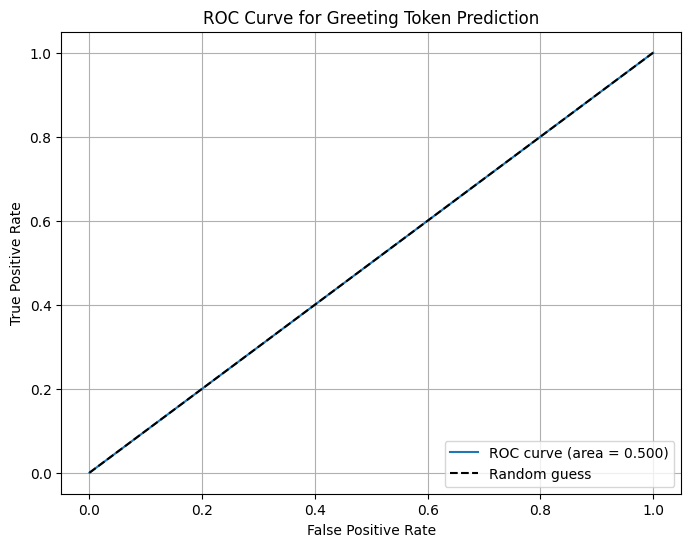

In [ ]:
# -------------------------------------
# Main Execution
# -------------------------------------
if __name__ == "__main__":
    trained_model, val_loader, seq_length = train_model()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    evaluate_roc_ks(trained_model, val_loader, seq_length, device)
